# MLP Trained on the Fashion-MNIST Dataset Using Tensorflow

In [27]:
!pip install wandb -qU

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping

import wandb
from wandb.keras import WandbCallback

from matplotlib import pyplot as plt

from pprint import pprint

## Login to Wandb

In [29]:
wandb.login()

True

## Load Fashion-MNIST

In [30]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Plot some examples

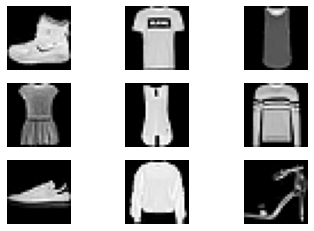

In [32]:
i = 0

for picture in x_train[:9]:
    plt.subplot(3, 3, i+1)
    plt.imshow(picture, cmap='gray')
    plt.axis('off')
    i = i + 1

plt.show()

## Create MLP

In [33]:
def create_model(config):
  model = Sequential([
      Rescaling(scale=1./255, input_shape=(28, 28)),
      Flatten(),
      
      Dense(config.dense_1, activation='relu'),
      Dense(config.dense_2, activation='relu'),
      Dense(config.dense_3, activation='relu'),
      Dense(config.dense_4, activation='relu'),

      Dense(10, activation='softmax'),
  ])

  return model

## Compile model

In [34]:
def compile_model(model, config):
  model.compile(
      optimizer=SGD(learning_rate=config.learning_rate, momentum=config.momentum),
      loss=SparseCategoricalCrossentropy(),
      metrics=[SparseCategoricalAccuracy()]
  )

## Train model

In [35]:
def train_model(model, config, x_train, y_train):
  early_stopping = EarlyStopping(
      monitor='val_loss', 
      mode='min', 
      verbose=1,
      patience=5,
      restore_best_weights=True
  )
  history = model.fit(
      x_train,
      y_train,
      epochs=config.epochs,
      validation_split=0.2,
      batch_size=config.batch_size,
      shuffle=True,
      callbacks=[
          early_stopping,
          WandbCallback()
      ]
  )

  return history

## Define sweep agent function

In [36]:
def sweep_train():
  default_config = {
      'dense_1': 512,
      'dense_2': 256,
      'dense_3': 256,
      'dense_4': 64,
      'learning_rate': 0.001,
      'momentum': 0.0,
      'epochs': 300,
      'batch_size': 128,
  }

  wandb.init(config=default_config)

  config = wandb.config

  mlp = create_model(config)
  mlp.summary()
  compile_model(mlp, config)
  history = train_model(mlp, config, x_train, y_train)
  mlp.evaluate(x_test, y_test)

## Configure Wandb Sweep for Hyperparameter Tuning

In [37]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'early_terminate':{
        'type': 'hyperband',
        'min_iter': 5
    },
    'parameters': {
        'batch_size': {
            'values': [32, 64, 128]
        },
        'learning_rate': {
            'min': 0.0001,
            'max': 0.1
        },
        'momentum': {
            'min': 0.0,
            'max': 0.9
        },
        'dense_1': {
            'min': 256,
            'max': 512
        },
        'dense_2': {
            'min': 128,
            'max': 256
        },
        'dense_3': {
            'min': 128,
            'max': 256
        },
        'dense_4': {
            'min': 32,
            'max': 64
        }
    }
}

pprint(sweep_config)

sweep_id = wandb.sweep(sweep_config, project='tf_mlp')

{'early_terminate': {'min_iter': 5, 'type': 'hyperband'},
 'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'batch_size': {'values': [32, 64, 128]},
                'dense_1': {'max': 512, 'min': 256},
                'dense_2': {'max': 256, 'min': 128},
                'dense_3': {'max': 256, 'min': 128},
                'dense_4': {'max': 64, 'min': 32},
                'learning_rate': {'max': 0.1, 'min': 0.0001},
                'momentum': {'max': 0.9, 'min': 0.0}}}
Create sweep with ID: lon5tp0z
Sweep URL: https://wandb.ai/nsiete23/tf_mlp/sweeps/lon5tp0z


## Run sweep

In [38]:
wandb.agent(sweep_id, function=sweep_train, count=20)

wandb: Agent Starting Run: sv0blq9p with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 362
wandb: 	dense_2: 186
wandb: 	dense_3: 160
wandb: 	dense_4: 51
wandb: 	learning_rate: 0.07427816705673913
wandb: 	momentum: 0.6711997242828291
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 362)               284170    
                                                                 
 dense_1 (Dense)             (None, 186)               67518     
                                                                 
 dense_2 (Dense)             (None, 160)               29920     
                                                                 
 dense_3 (Dense)             (None, 51)                8211      
                                                                 
 dense_4 (Dense)             (None, 10)                5

1498/1500 [============================>.] - ETA: 0s - loss: 0.5634 - sparse_categorical_accuracy: 0.7915

wandb: Adding directory to artifact (/content/wandb/run-20230224_185615-sv0blq9p/files/model-best)... Done. 0.1s


1500/1500 [==============================] - 14s 8ms/step - loss: 0.5633 - sparse_categorical_accuracy: 0.7916 - val_loss: 0.5198 - val_sparse_categorical_accuracy: 0.8153
Epoch 2/300
1495/1500 [============================>.] - ETA: 0s - loss: 0.4099 - sparse_categorical_accuracy: 0.8493

wandb: Adding directory to artifact (/content/wandb/run-20230224_185615-sv0blq9p/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.4098 - sparse_categorical_accuracy: 0.8493 - val_loss: 0.3916 - val_sparse_categorical_accuracy: 0.8537
Epoch 3/300
1490/1500 [============================>.] - ETA: 0s - loss: 0.3690 - sparse_categorical_accuracy: 0.8631

wandb: Adding directory to artifact (/content/wandb/run-20230224_185615-sv0blq9p/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3687 - sparse_categorical_accuracy: 0.8634 - val_loss: 0.3870 - val_sparse_categorical_accuracy: 0.8625
Epoch 4/300
1487/1500 [============================>.] - ETA: 0s - loss: 0.3410 - sparse_categorical_accuracy: 0.8741

wandb: Adding directory to artifact (/content/wandb/run-20230224_185615-sv0blq9p/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.3406 - sparse_categorical_accuracy: 0.8743 - val_loss: 0.3861 - val_sparse_categorical_accuracy: 0.8606
Epoch 5/300
1492/1500 [============================>.] - ETA: 0s - loss: 0.3197 - sparse_categorical_accuracy: 0.8815

wandb: Adding directory to artifact (/content/wandb/run-20230224_185615-sv0blq9p/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3201 - sparse_categorical_accuracy: 0.8812 - val_loss: 0.3551 - val_sparse_categorical_accuracy: 0.8662
Epoch 6/300
1499/1500 [============================>.] - ETA: 0s - loss: 0.3066 - sparse_categorical_accuracy: 0.8874

wandb: Adding directory to artifact (/content/wandb/run-20230224_185615-sv0blq9p/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3065 - sparse_categorical_accuracy: 0.8874 - val_loss: 0.3427 - val_sparse_categorical_accuracy: 0.8767
Epoch 7/300
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2922 - sparse_categorical_accuracy: 0.8927 - val_loss: 0.3927 - val_sparse_categorical_accuracy: 0.8618
Epoch 8/300
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2823 - sparse_categorical_accuracy: 0.8947 - val_loss: 0.3597 - val_sparse_categorical_accuracy: 0.8705
Epoch 9/300
1486/1500 [============================>.] - ETA: 0s - loss: 0.2710 - sparse_categorical_accuracy: 0.8984

wandb: Adding directory to artifact (/content/wandb/run-20230224_185615-sv0blq9p/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 5ms/step - loss: 0.2707 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.3140 - val_sparse_categorical_accuracy: 0.8852
Epoch 10/300
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2619 - sparse_categorical_accuracy: 0.9016 - val_loss: 0.3354 - val_sparse_categorical_accuracy: 0.8823
Epoch 11/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2552 - sparse_categorical_accuracy: 0.9027 - val_loss: 0.3363 - val_sparse_categorical_accuracy: 0.8842
Epoch 12/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2454 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.3140 - val_sparse_categorical_accuracy: 0.8892
Epoch 13/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2398 - sparse_categorical_accuracy: 0.9084 - val_loss: 0.3615 - val_sparse_categorical_accuracy: 0.8796
Epoch 14/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2340 - sparse

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▇▇▇▇▇▇███
val_loss,█▄▃▃▂▂▄▃▁▂▂▁▃▂
val_sparse_categorical_accuracy,▁▅▅▅▆▇▅▆▇▇▇█▇█
best_epoch,8
best_val_loss,0.31395
epoch,13
loss,0.23401
sparse_categorical_accuracy,0.91221
val_loss,0.33594


wandb: Agent Starting Run: fnogva7g with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 493
wandb: 	dense_2: 200
wandb: 	dense_3: 141
wandb: 	dense_4: 46
wandb: 	learning_rate: 0.03260346417592236
wandb: 	momentum: 0.5818575160144305
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 493)               387005    
                                                                 
 dense_1 (Dense)             (None, 200)               98800     
                                                                 
 dense_2 (Dense)             (None, 141)               28341     
                                                                 
 dense_3 (Dense)             (None, 46)                6532      
                                                                 
 dense_4 (Dense)             (None, 10)                4

wandb: Adding directory to artifact (/content/wandb/run-20230224_185814-fnogva7g/files/model-best)... Done. 0.0s


750/750 [==============================] - 6s 7ms/step - loss: 0.6061 - sparse_categorical_accuracy: 0.7823 - val_loss: 0.4141 - val_sparse_categorical_accuracy: 0.8523
Epoch 2/300
742/750 [============================>.] - ETA: 0s - loss: 0.4048 - sparse_categorical_accuracy: 0.8534

wandb: Adding directory to artifact (/content/wandb/run-20230224_185814-fnogva7g/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.4042 - sparse_categorical_accuracy: 0.8538 - val_loss: 0.3797 - val_sparse_categorical_accuracy: 0.8643
Epoch 3/300
750/750 [==============================] - 3s 4ms/step - loss: 0.3619 - sparse_categorical_accuracy: 0.8670 - val_loss: 0.4178 - val_sparse_categorical_accuracy: 0.8405
Epoch 4/300
746/750 [============================>.] - ETA: 0s - loss: 0.3310 - sparse_categorical_accuracy: 0.8782

wandb: Adding directory to artifact (/content/wandb/run-20230224_185814-fnogva7g/files/model-best)... Done. 0.0s


750/750 [==============================] - 6s 7ms/step - loss: 0.3311 - sparse_categorical_accuracy: 0.8782 - val_loss: 0.3665 - val_sparse_categorical_accuracy: 0.8652
Epoch 5/300
738/750 [============================>.] - ETA: 0s - loss: 0.3092 - sparse_categorical_accuracy: 0.8866

wandb: Adding directory to artifact (/content/wandb/run-20230224_185814-fnogva7g/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.3088 - sparse_categorical_accuracy: 0.8866 - val_loss: 0.3486 - val_sparse_categorical_accuracy: 0.8748
Epoch 6/300
734/750 [============================>.] - ETA: 0s - loss: 0.2935 - sparse_categorical_accuracy: 0.8906

wandb: Adding directory to artifact (/content/wandb/run-20230224_185814-fnogva7g/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.2940 - sparse_categorical_accuracy: 0.8904 - val_loss: 0.3299 - val_sparse_categorical_accuracy: 0.8820
Epoch 7/300
742/750 [============================>.] - ETA: 0s - loss: 0.2792 - sparse_categorical_accuracy: 0.8961

wandb: Adding directory to artifact (/content/wandb/run-20230224_185814-fnogva7g/files/model-best)... Done. 0.0s


750/750 [==============================] - 6s 8ms/step - loss: 0.2790 - sparse_categorical_accuracy: 0.8961 - val_loss: 0.3258 - val_sparse_categorical_accuracy: 0.8832
Epoch 8/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2650 - sparse_categorical_accuracy: 0.9001 - val_loss: 0.3377 - val_sparse_categorical_accuracy: 0.8789
Epoch 9/300
745/750 [============================>.] - ETA: 0s - loss: 0.2543 - sparse_categorical_accuracy: 0.9040

wandb: Adding directory to artifact (/content/wandb/run-20230224_185814-fnogva7g/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.2542 - sparse_categorical_accuracy: 0.9041 - val_loss: 0.3180 - val_sparse_categorical_accuracy: 0.8837
Epoch 10/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2448 - sparse_categorical_accuracy: 0.9083 - val_loss: 0.3328 - val_sparse_categorical_accuracy: 0.8852
Epoch 11/300
734/750 [============================>.] - ETA: 0s - loss: 0.2349 - sparse_categorical_accuracy: 0.9124

wandb: Adding directory to artifact (/content/wandb/run-20230224_185814-fnogva7g/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 6ms/step - loss: 0.2349 - sparse_categorical_accuracy: 0.9124 - val_loss: 0.3159 - val_sparse_categorical_accuracy: 0.8859
Epoch 12/300
742/750 [============================>.] - ETA: 0s - loss: 0.2258 - sparse_categorical_accuracy: 0.9155

wandb: Adding directory to artifact (/content/wandb/run-20230224_185814-fnogva7g/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.2252 - sparse_categorical_accuracy: 0.9158 - val_loss: 0.3061 - val_sparse_categorical_accuracy: 0.8923
Epoch 13/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2153 - sparse_categorical_accuracy: 0.9199 - val_loss: 0.3378 - val_sparse_categorical_accuracy: 0.8873
Epoch 14/300
750/750 [==============================] - 4s 5ms/step - loss: 0.2075 - sparse_categorical_accuracy: 0.9220 - val_loss: 0.3076 - val_sparse_categorical_accuracy: 0.8901
Epoch 15/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1995 - sparse_categorical_accuracy: 0.9241 - val_loss: 0.3146 - val_sparse_categorical_accuracy: 0.8928
Epoch 16/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1961 - sparse_categorical_accuracy: 0.9258 - val_loss: 0.3314 - val_sparse_categorical_accuracy: 0.8909
Epoch 17/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1880 - sparse_categorical

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇█████
val_loss,█▆█▅▄▂▂▃▂▃▂▁▃▁▂▃▂
val_sparse_categorical_accuracy,▃▄▁▄▆▇▇▆▇▇▇█▇████
best_epoch,11
best_val_loss,0.30612
epoch,16
loss,0.18796
sparse_categorical_accuracy,0.92827
val_loss,0.32721


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y41hvbim with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 384
wandb: 	dense_2: 144
wandb: 	dense_3: 164
wandb: 	dense_4: 36
wandb: 	learning_rate: 0.09239580141344536
wandb: 	momentum: 0.4958902085994566
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 384)               301440    
                                                                 
 dense_1 (Dense)             (None, 144)               55440     
                                                                 
 dense_2 (Dense)             (None, 164)               23780     
                                                                 
 dense_3 (Dense)             (None, 36)                5940      
                                                                 
 dense_4 (Dense)             (None, 10)                3

wandb: Adding directory to artifact (/content/wandb/run-20230224_190006-y41hvbim/files/model-best)... Done. 0.0s


750/750 [==============================] - 6s 7ms/step - loss: 0.5924 - sparse_categorical_accuracy: 0.7833 - val_loss: 0.4103 - val_sparse_categorical_accuracy: 0.8497
Epoch 2/300
742/750 [============================>.] - ETA: 0s - loss: 0.4012 - sparse_categorical_accuracy: 0.8529

wandb: Adding directory to artifact (/content/wandb/run-20230224_190006-y41hvbim/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.4012 - sparse_categorical_accuracy: 0.8528 - val_loss: 0.4092 - val_sparse_categorical_accuracy: 0.8543
Epoch 3/300
747/750 [============================>.] - ETA: 0s - loss: 0.3583 - sparse_categorical_accuracy: 0.8685

wandb: Adding directory to artifact (/content/wandb/run-20230224_190006-y41hvbim/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.3581 - sparse_categorical_accuracy: 0.8685 - val_loss: 0.3703 - val_sparse_categorical_accuracy: 0.8632
Epoch 4/300
745/750 [============================>.] - ETA: 0s - loss: 0.3317 - sparse_categorical_accuracy: 0.8763

wandb: Adding directory to artifact (/content/wandb/run-20230224_190006-y41hvbim/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.3319 - sparse_categorical_accuracy: 0.8763 - val_loss: 0.3463 - val_sparse_categorical_accuracy: 0.8736
Epoch 5/300
740/750 [============================>.] - ETA: 0s - loss: 0.3097 - sparse_categorical_accuracy: 0.8851

wandb: Adding directory to artifact (/content/wandb/run-20230224_190006-y41hvbim/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.3096 - sparse_categorical_accuracy: 0.8853 - val_loss: 0.3292 - val_sparse_categorical_accuracy: 0.8789
Epoch 6/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2944 - sparse_categorical_accuracy: 0.8900 - val_loss: 0.3321 - val_sparse_categorical_accuracy: 0.8796
Epoch 7/300
750/750 [==============================] - 4s 5ms/step - loss: 0.2808 - sparse_categorical_accuracy: 0.8956 - val_loss: 0.3598 - val_sparse_categorical_accuracy: 0.8698
Epoch 8/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2673 - sparse_categorical_accuracy: 0.8986 - val_loss: 0.3299 - val_sparse_categorical_accuracy: 0.8839
Epoch 9/300
737/750 [============================>.] - ETA: 0s - loss: 0.2531 - sparse_categorical_accuracy: 0.9059

wandb: Adding directory to artifact (/content/wandb/run-20230224_190006-y41hvbim/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.2546 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.3132 - val_sparse_categorical_accuracy: 0.8866
Epoch 10/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2457 - sparse_categorical_accuracy: 0.9077 - val_loss: 0.3232 - val_sparse_categorical_accuracy: 0.8837
Epoch 11/300
750/750 [==============================] - 4s 5ms/step - loss: 0.2399 - sparse_categorical_accuracy: 0.9088 - val_loss: 0.3419 - val_sparse_categorical_accuracy: 0.8746
Epoch 12/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2299 - sparse_categorical_accuracy: 0.9122 - val_loss: 0.3377 - val_sparse_categorical_accuracy: 0.8849
Epoch 13/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2240 - sparse_categorical_accuracy: 0.9140 - val_loss: 0.3187 - val_sparse_categorical_accuracy: 0.8850
Epoch 14/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2198 - sparse_categorical

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▄▄▃▃▂▂▂▂▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▇▇▇▇█████
val_loss,██▅▃▂▂▄▂▁▂▃▃▁▁
val_sparse_categorical_accuracy,▁▂▃▅▆▆▄▇▇▇▅▇▇█
best_epoch,8
best_val_loss,0.31319
epoch,13
loss,0.21984
sparse_categorical_accuracy,0.91708
val_loss,0.3157


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ico8p6ts with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 502
wandb: 	dense_2: 243
wandb: 	dense_3: 185
wandb: 	dense_4: 44
wandb: 	learning_rate: 0.07546368012497573
wandb: 	momentum: 0.35358161803634547


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 502)               394070    
                                                                 
 dense_1 (Dense)             (None, 243)               122229    
                                                                 
 dense_2 (Dense)             (None, 185)               45140     
                                                                 
 dense_3 (Dense)             (None, 44)                8184      
                                                                 
 dense_4 (Dense)             (None, 10)                4

wandb: Adding directory to artifact (/content/wandb/run-20230224_190130-ico8p6ts/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 9s 6ms/step - loss: 0.5419 - sparse_categorical_accuracy: 0.8023 - val_loss: 0.4132 - val_sparse_categorical_accuracy: 0.8495
Epoch 2/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3945 - sparse_categorical_accuracy: 0.8534 - val_loss: 0.4245 - val_sparse_categorical_accuracy: 0.8351
Epoch 3/300
1496/1500 [============================>.] - ETA: 0s - loss: 0.3505 - sparse_categorical_accuracy: 0.8703

wandb: Adding directory to artifact (/content/wandb/run-20230224_190130-ico8p6ts/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.3504 - sparse_categorical_accuracy: 0.8703 - val_loss: 0.3548 - val_sparse_categorical_accuracy: 0.8729
Epoch 4/300
1490/1500 [============================>.] - ETA: 0s - loss: 0.3233 - sparse_categorical_accuracy: 0.8795

wandb: Adding directory to artifact (/content/wandb/run-20230224_190130-ico8p6ts/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 6s 4ms/step - loss: 0.3238 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.3462 - val_sparse_categorical_accuracy: 0.8723
Epoch 5/300
1494/1500 [============================>.] - ETA: 0s - loss: 0.3037 - sparse_categorical_accuracy: 0.8860

wandb: Adding directory to artifact (/content/wandb/run-20230224_190130-ico8p6ts/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.3034 - sparse_categorical_accuracy: 0.8861 - val_loss: 0.3453 - val_sparse_categorical_accuracy: 0.8725
Epoch 6/300
1488/1500 [============================>.] - ETA: 0s - loss: 0.2856 - sparse_categorical_accuracy: 0.8923

wandb: Adding directory to artifact (/content/wandb/run-20230224_190130-ico8p6ts/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 6s 4ms/step - loss: 0.2858 - sparse_categorical_accuracy: 0.8923 - val_loss: 0.3265 - val_sparse_categorical_accuracy: 0.8773
Epoch 7/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2711 - sparse_categorical_accuracy: 0.8978 - val_loss: 0.3838 - val_sparse_categorical_accuracy: 0.8604
Epoch 8/300
1487/1500 [============================>.] - ETA: 0s - loss: 0.2592 - sparse_categorical_accuracy: 0.9022

wandb: Adding directory to artifact (/content/wandb/run-20230224_190130-ico8p6ts/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 6s 4ms/step - loss: 0.2591 - sparse_categorical_accuracy: 0.9021 - val_loss: 0.3192 - val_sparse_categorical_accuracy: 0.8856
Epoch 9/300
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2501 - sparse_categorical_accuracy: 0.9044 - val_loss: 0.3316 - val_sparse_categorical_accuracy: 0.8808
Epoch 10/300
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2408 - sparse_categorical_accuracy: 0.9083 - val_loss: 0.3588 - val_sparse_categorical_accuracy: 0.8755
Epoch 11/300
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2289 - sparse_categorical_accuracy: 0.9114 - val_loss: 0.3202 - val_sparse_categorical_accuracy: 0.8854
Epoch 12/300
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2235 - sparse_categorical_accuracy: 0.9126 - val_loss: 0.3666 - val_sparse_categorical_accuracy: 0.8761
Epoch 13/300
1483/1500 [============================>.] - ETA: 0s - loss: 0.2165 - sparse_cate

wandb: Adding directory to artifact (/content/wandb/run-20230224_190130-ico8p6ts/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 4ms/step - loss: 0.2165 - sparse_categorical_accuracy: 0.9165 - val_loss: 0.3192 - val_sparse_categorical_accuracy: 0.8945
Epoch 14/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2115 - sparse_categorical_accuracy: 0.9199 - val_loss: 0.3547 - val_sparse_categorical_accuracy: 0.8828
Epoch 15/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2014 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.3233 - val_sparse_categorical_accuracy: 0.8908
Epoch 16/300
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1966 - sparse_categorical_accuracy: 0.9251 - val_loss: 0.3429 - val_sparse_categorical_accuracy: 0.8832
Epoch 17/300
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1903 - sparse_categorical_accuracy: 0.9264 - val_loss: 0.3419 - val_sparse_categorical_accuracy: 0.8880
Epoch 18/300
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1827 - sparse

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇████
val_loss,▇█▃▃▃▁▅▁▂▄▁▄▁▃▁▃▃▁
val_sparse_categorical_accuracy,▃▁▅▅▅▆▄▇▆▆▇▆█▇█▇▇█
best_epoch,12
best_val_loss,0.3192
epoch,17
loss,0.18267
sparse_categorical_accuracy,0.9296
val_loss,0.32236


wandb: Agent Starting Run: 8fa87jun with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 279
wandb: 	dense_2: 148
wandb: 	dense_3: 256
wandb: 	dense_4: 61
wandb: 	learning_rate: 0.012253502058456331
wandb: 	momentum: 0.1109342795319852
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 279)               219015    
                                                                 
 dense_1 (Dense)             (None, 148)               41440     
                                                                 
 dense_2 (Dense)             (None, 256)               38144     
                                                                 
 dense_3 (Dense)             (None, 61)                15677     
                                                                 
 dense_4 (Dense)             (None, 10)                6

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 5s 11ms/step - loss: 1.1213 - sparse_categorical_accuracy: 0.6360 - val_loss: 0.6813 - val_sparse_categorical_accuracy: 0.7592
Epoch 2/300
370/375 [============================>.] - ETA: 0s - loss: 0.6304 - sparse_categorical_accuracy: 0.7808

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7811 - val_loss: 0.6271 - val_sparse_categorical_accuracy: 0.7660
Epoch 3/300
370/375 [============================>.] - ETA: 0s - loss: 0.5415 - sparse_categorical_accuracy: 0.8103

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.5409 - sparse_categorical_accuracy: 0.8106 - val_loss: 0.5211 - val_sparse_categorical_accuracy: 0.8168
Epoch 4/300
365/375 [============================>.] - ETA: 0s - loss: 0.4976 - sparse_categorical_accuracy: 0.8257

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.4968 - sparse_categorical_accuracy: 0.8257 - val_loss: 0.4790 - val_sparse_categorical_accuracy: 0.8300
Epoch 5/300
375/375 [==============================] - 2s 5ms/step - loss: 0.4668 - sparse_categorical_accuracy: 0.8356 - val_loss: 0.4951 - val_sparse_categorical_accuracy: 0.8163
Epoch 6/300
365/375 [============================>.] - ETA: 0s - loss: 0.4451 - sparse_categorical_accuracy: 0.8452

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 11ms/step - loss: 0.4451 - sparse_categorical_accuracy: 0.8452 - val_loss: 0.4641 - val_sparse_categorical_accuracy: 0.8383
Epoch 7/300
365/375 [============================>.] - ETA: 0s - loss: 0.4295 - sparse_categorical_accuracy: 0.8491

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.4293 - sparse_categorical_accuracy: 0.8492 - val_loss: 0.4308 - val_sparse_categorical_accuracy: 0.8480
Epoch 8/300
375/375 [==============================] - 2s 4ms/step - loss: 0.4147 - sparse_categorical_accuracy: 0.8540 - val_loss: 0.4316 - val_sparse_categorical_accuracy: 0.8488
Epoch 9/300
375/375 [==============================] - ETA: 0s - loss: 0.4039 - sparse_categorical_accuracy: 0.8576

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.4039 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.4186 - val_sparse_categorical_accuracy: 0.8533
Epoch 10/300
374/375 [============================>.] - ETA: 0s - loss: 0.3932 - sparse_categorical_accuracy: 0.8612

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.3931 - sparse_categorical_accuracy: 0.8612 - val_loss: 0.4100 - val_sparse_categorical_accuracy: 0.8572
Epoch 11/300
362/375 [===========================>..] - ETA: 0s - loss: 0.3835 - sparse_categorical_accuracy: 0.8655

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3829 - sparse_categorical_accuracy: 0.8656 - val_loss: 0.4032 - val_sparse_categorical_accuracy: 0.8558
Epoch 12/300
375/375 [==============================] - ETA: 0s - loss: 0.3760 - sparse_categorical_accuracy: 0.8669

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3760 - sparse_categorical_accuracy: 0.8669 - val_loss: 0.3875 - val_sparse_categorical_accuracy: 0.8644
Epoch 13/300
359/375 [===========================>..] - ETA: 0s - loss: 0.3698 - sparse_categorical_accuracy: 0.8699

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3694 - sparse_categorical_accuracy: 0.8697 - val_loss: 0.3850 - val_sparse_categorical_accuracy: 0.8670
Epoch 14/300
375/375 [==============================] - 2s 4ms/step - loss: 0.3596 - sparse_categorical_accuracy: 0.8724 - val_loss: 0.3923 - val_sparse_categorical_accuracy: 0.8592
Epoch 15/300
367/375 [============================>.] - ETA: 0s - loss: 0.3543 - sparse_categorical_accuracy: 0.8732

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.3547 - sparse_categorical_accuracy: 0.8731 - val_loss: 0.3682 - val_sparse_categorical_accuracy: 0.8714
Epoch 16/300
375/375 [==============================] - 2s 5ms/step - loss: 0.3480 - sparse_categorical_accuracy: 0.8761 - val_loss: 0.3698 - val_sparse_categorical_accuracy: 0.8689
Epoch 17/300
374/375 [============================>.] - ETA: 0s - loss: 0.3420 - sparse_categorical_accuracy: 0.8771

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3419 - sparse_categorical_accuracy: 0.8771 - val_loss: 0.3617 - val_sparse_categorical_accuracy: 0.8718
Epoch 18/300
375/375 [==============================] - 2s 4ms/step - loss: 0.3371 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.3633 - val_sparse_categorical_accuracy: 0.8718
Epoch 19/300
362/375 [===========================>..] - ETA: 0s - loss: 0.3312 - sparse_categorical_accuracy: 0.8821

wandb: Adding directory to artifact (/content/wandb/run-20230224_190350-8fa87jun/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3311 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.3527 - val_sparse_categorical_accuracy: 0.8754
Epoch 20/300
375/375 [==============================] - 2s 4ms/step - loss: 0.3248 - sparse_categorical_accuracy: 0.8837 - val_loss: 0.3629 - val_sparse_categorical_accuracy: 0.8723
Epoch 21/300
375/375 [==============================] - 2s 4ms/step - loss: 0.3210 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.3634 - val_sparse_categorical_accuracy: 0.8696
Epoch 22/300
375/375 [==============================] - 2s 6ms/step - loss: 0.3146 - sparse_categorical_accuracy: 0.8863 - val_loss: 0.3542 - val_sparse_categorical_accuracy: 0.8742
Epoch 23/300
375/375 [==============================] - 1s 4ms/step - loss: 0.3144 - sparse_categorical_accuracy: 0.8866 - val_loss: 0.3613 - val_sparse_categorical_accuracy: 0.8710
Epoch 24/300
375/375 [==============================] - 1s 4ms/step - loss: 0.3074 - sparse_categorical

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇███████████
val_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▁▄▅▄▆▆▆▇▇▇▇▇▇██████████
best_epoch,18
best_val_loss,0.35265
epoch,23
loss,0.30739
sparse_categorical_accuracy,0.889
val_loss,0.3596


wandb: Agent Starting Run: 5fljcbdo with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 352
wandb: 	dense_2: 245
wandb: 	dense_3: 244
wandb: 	dense_4: 53
wandb: 	learning_rate: 0.049540208369070055
wandb: 	momentum: 0.49134514772532506
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 352)               276320    
                                                                 
 dense_1 (Dense)             (None, 245)               86485     
                                                                 
 dense_2 (Dense)             (None, 244)               60024     
                                                                 
 dense_3 (Dense)             (None, 53)                12985     
                                                                 
 dense_4 (Dense)             (None, 10)                5

wandb: Adding directory to artifact (/content/wandb/run-20230224_190533-5fljcbdo/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 9ms/step - loss: 0.6586 - sparse_categorical_accuracy: 0.7676 - val_loss: 0.4538 - val_sparse_categorical_accuracy: 0.8400
Epoch 2/300
371/375 [============================>.] - ETA: 0s - loss: 0.4326 - sparse_categorical_accuracy: 0.8430

wandb: Adding directory to artifact (/content/wandb/run-20230224_190533-5fljcbdo/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.4320 - sparse_categorical_accuracy: 0.8431 - val_loss: 0.4024 - val_sparse_categorical_accuracy: 0.8549
Epoch 3/300
360/375 [===========================>..] - ETA: 0s - loss: 0.3790 - sparse_categorical_accuracy: 0.8620

wandb: Adding directory to artifact (/content/wandb/run-20230224_190533-5fljcbdo/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3767 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.3783 - val_sparse_categorical_accuracy: 0.8615
Epoch 4/300
370/375 [============================>.] - ETA: 0s - loss: 0.3483 - sparse_categorical_accuracy: 0.8721

wandb: Adding directory to artifact (/content/wandb/run-20230224_190533-5fljcbdo/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.3479 - sparse_categorical_accuracy: 0.8723 - val_loss: 0.3620 - val_sparse_categorical_accuracy: 0.8663
Epoch 5/300
367/375 [============================>.] - ETA: 0s - loss: 0.3262 - sparse_categorical_accuracy: 0.8796

wandb: Adding directory to artifact (/content/wandb/run-20230224_190533-5fljcbdo/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.3267 - sparse_categorical_accuracy: 0.8794 - val_loss: 0.3519 - val_sparse_categorical_accuracy: 0.8711
Epoch 6/300
369/375 [============================>.] - ETA: 0s - loss: 0.3081 - sparse_categorical_accuracy: 0.8874

wandb: Adding directory to artifact (/content/wandb/run-20230224_190533-5fljcbdo/files/model-best)... Done. 0.0s


375/375 [==============================] - 2s 6ms/step - loss: 0.3081 - sparse_categorical_accuracy: 0.8874 - val_loss: 0.3393 - val_sparse_categorical_accuracy: 0.8790
Epoch 7/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2963 - sparse_categorical_accuracy: 0.8895 - val_loss: 0.3634 - val_sparse_categorical_accuracy: 0.8677
Epoch 8/300
367/375 [============================>.] - ETA: 0s - loss: 0.2810 - sparse_categorical_accuracy: 0.8949

wandb: Adding directory to artifact (/content/wandb/run-20230224_190533-5fljcbdo/files/model-best)... Done. 0.0s


375/375 [==============================] - 2s 7ms/step - loss: 0.2813 - sparse_categorical_accuracy: 0.8946 - val_loss: 0.3276 - val_sparse_categorical_accuracy: 0.8790
Epoch 9/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2696 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.3710 - val_sparse_categorical_accuracy: 0.8651
Epoch 10/300
368/375 [============================>.] - ETA: 0s - loss: 0.2621 - sparse_categorical_accuracy: 0.9011

wandb: Adding directory to artifact (/content/wandb/run-20230224_190533-5fljcbdo/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.2620 - sparse_categorical_accuracy: 0.9013 - val_loss: 0.3242 - val_sparse_categorical_accuracy: 0.8807
Epoch 11/300
375/375 [==============================] - ETA: 0s - loss: 0.2513 - sparse_categorical_accuracy: 0.9064

wandb: Adding directory to artifact (/content/wandb/run-20230224_190533-5fljcbdo/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 9ms/step - loss: 0.2513 - sparse_categorical_accuracy: 0.9064 - val_loss: 0.3090 - val_sparse_categorical_accuracy: 0.8896
Epoch 12/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2393 - sparse_categorical_accuracy: 0.9097 - val_loss: 0.3184 - val_sparse_categorical_accuracy: 0.8840
Epoch 13/300
362/375 [===========================>..] - ETA: 0s - loss: 0.2342 - sparse_categorical_accuracy: 0.9111

wandb: Adding directory to artifact (/content/wandb/run-20230224_190533-5fljcbdo/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2336 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.3086 - val_sparse_categorical_accuracy: 0.8915
Epoch 14/300
375/375 [==============================] - 2s 5ms/step - loss: 0.2243 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.3132 - val_sparse_categorical_accuracy: 0.8883
Epoch 15/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2160 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.3414 - val_sparse_categorical_accuracy: 0.8794
Epoch 16/300
375/375 [==============================] - 2s 5ms/step - loss: 0.2105 - sparse_categorical_accuracy: 0.9208 - val_loss: 0.3304 - val_sparse_categorical_accuracy: 0.8846
Epoch 17/300
375/375 [==============================] - 2s 6ms/step - loss: 0.2017 - sparse_categorical_accuracy: 0.9239 - val_loss: 0.3364 - val_sparse_categorical_accuracy: 0.8824
Epoch 18/300
375/375 [==============================] - 2s 4ms/step - loss: 0.1981 - sparse_categorical

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇█████
val_loss,█▆▄▄▃▂▄▂▄▂▁▁▁▁▃▂▂▁
val_sparse_categorical_accuracy,▁▃▄▅▅▆▅▆▄▆█▇█▇▆▇▇█
best_epoch,12
best_val_loss,0.30864
epoch,17
loss,0.19811
sparse_categorical_accuracy,0.92442
val_loss,0.31615


wandb: Agent Starting Run: fes7u6lu with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 265
wandb: 	dense_2: 251
wandb: 	dense_3: 160
wandb: 	dense_4: 61
wandb: 	learning_rate: 0.03535812394645914
wandb: 	momentum: 0.828686337533291
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 265)               208025    
                                                                 
 dense_1 (Dense)             (None, 251)               66766     
                                                                 
 dense_2 (Dense)             (None, 160)               40320     
                                                                 
 dense_3 (Dense)             (None, 61)                9821      
                                                                 
 dense_4 (Dense)             (None, 10)                6

wandb: Adding directory to artifact (/content/wandb/run-20230224_190718-fes7u6lu/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 4ms/step - loss: 0.5581 - sparse_categorical_accuracy: 0.7959 - val_loss: 0.4282 - val_sparse_categorical_accuracy: 0.8433
Epoch 2/300
1500/1500 [==============================] - ETA: 0s - loss: 0.4079 - sparse_categorical_accuracy: 0.8513

wandb: Adding directory to artifact (/content/wandb/run-20230224_190718-fes7u6lu/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.4079 - sparse_categorical_accuracy: 0.8513 - val_loss: 0.4240 - val_sparse_categorical_accuracy: 0.8484
Epoch 3/300
1496/1500 [============================>.] - ETA: 0s - loss: 0.3631 - sparse_categorical_accuracy: 0.8656

wandb: Adding directory to artifact (/content/wandb/run-20230224_190718-fes7u6lu/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 9s 6ms/step - loss: 0.3629 - sparse_categorical_accuracy: 0.8656 - val_loss: 0.3928 - val_sparse_categorical_accuracy: 0.8527
Epoch 4/300
1499/1500 [============================>.] - ETA: 0s - loss: 0.3391 - sparse_categorical_accuracy: 0.8755

wandb: Adding directory to artifact (/content/wandb/run-20230224_190718-fes7u6lu/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3391 - sparse_categorical_accuracy: 0.8755 - val_loss: 0.3568 - val_sparse_categorical_accuracy: 0.8687
Epoch 5/300
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3204 - sparse_categorical_accuracy: 0.8804 - val_loss: 0.3748 - val_sparse_categorical_accuracy: 0.8664
Epoch 6/300
1498/1500 [============================>.] - ETA: 0s - loss: 0.3066 - sparse_categorical_accuracy: 0.8858

wandb: Adding directory to artifact (/content/wandb/run-20230224_190718-fes7u6lu/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3066 - sparse_categorical_accuracy: 0.8858 - val_loss: 0.3404 - val_sparse_categorical_accuracy: 0.8739
Epoch 7/300
1500/1500 [==============================] - ETA: 0s - loss: 0.2912 - sparse_categorical_accuracy: 0.8914

wandb: Adding directory to artifact (/content/wandb/run-20230224_190718-fes7u6lu/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.2912 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.3239 - val_sparse_categorical_accuracy: 0.8826
Epoch 8/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2800 - sparse_categorical_accuracy: 0.8957 - val_loss: 0.3328 - val_sparse_categorical_accuracy: 0.8809
Epoch 9/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2668 - sparse_categorical_accuracy: 0.8997 - val_loss: 0.3431 - val_sparse_categorical_accuracy: 0.8808
Epoch 10/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2610 - sparse_categorical_accuracy: 0.9020 - val_loss: 0.3315 - val_sparse_categorical_accuracy: 0.8822
Epoch 11/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2527 - sparse_categorical_accuracy: 0.9043 - val_loss: 0.3548 - val_sparse_categorical_accuracy: 0.8734
Epoch 12/300
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2430 - sparse_c

epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▅▄▃▃▂▂▂▂▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▇▇▇████
val_loss,██▆▃▄▂▁▂▂▂▃▁
val_sparse_categorical_accuracy,▁▂▂▅▅▆▇▇▇▇▆█
best_epoch,6
best_val_loss,0.32391
epoch,11
loss,0.24305
sparse_categorical_accuracy,0.90685
val_loss,0.32688


wandb: Agent Starting Run: 1flql71g with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 342
wandb: 	dense_2: 225
wandb: 	dense_3: 207
wandb: 	dense_4: 61
wandb: 	learning_rate: 0.025588826934708337
wandb: 	momentum: 0.4585743921529269
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 342)               268470    
                                                                 
 dense_1 (Dense)             (None, 225)               77175     
                                                                 
 dense_2 (Dense)             (None, 207)               46782     
                                                                 
 dense_3 (Dense)             (None, 61)                12688     
                                                                 
 dense_4 (Dense)             (None, 10)                6

wandb: Adding directory to artifact (/content/wandb/run-20230224_190901-1flql71g/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 6ms/step - loss: 0.6404 - sparse_categorical_accuracy: 0.7723 - val_loss: 0.4624 - val_sparse_categorical_accuracy: 0.8394
Epoch 2/300
746/750 [============================>.] - ETA: 0s - loss: 0.4222 - sparse_categorical_accuracy: 0.8476

wandb: Adding directory to artifact (/content/wandb/run-20230224_190901-1flql71g/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.4222 - sparse_categorical_accuracy: 0.8476 - val_loss: 0.4167 - val_sparse_categorical_accuracy: 0.8493
Epoch 3/300
742/750 [============================>.] - ETA: 0s - loss: 0.3758 - sparse_categorical_accuracy: 0.8641

wandb: Adding directory to artifact (/content/wandb/run-20230224_190901-1flql71g/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 6ms/step - loss: 0.3750 - sparse_categorical_accuracy: 0.8645 - val_loss: 0.3601 - val_sparse_categorical_accuracy: 0.8699
Epoch 4/300
750/750 [==============================] - 3s 4ms/step - loss: 0.3475 - sparse_categorical_accuracy: 0.8714 - val_loss: 0.3787 - val_sparse_categorical_accuracy: 0.8620
Epoch 5/300
749/750 [============================>.] - ETA: 0s - loss: 0.3250 - sparse_categorical_accuracy: 0.8806

wandb: Adding directory to artifact (/content/wandb/run-20230224_190901-1flql71g/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.3249 - sparse_categorical_accuracy: 0.8807 - val_loss: 0.3480 - val_sparse_categorical_accuracy: 0.8733
Epoch 6/300
750/750 [==============================] - 4s 5ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.8856 - val_loss: 0.3590 - val_sparse_categorical_accuracy: 0.8735
Epoch 7/300
747/750 [============================>.] - ETA: 0s - loss: 0.2930 - sparse_categorical_accuracy: 0.8912

wandb: Adding directory to artifact (/content/wandb/run-20230224_190901-1flql71g/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.2933 - sparse_categorical_accuracy: 0.8912 - val_loss: 0.3381 - val_sparse_categorical_accuracy: 0.8799
Epoch 8/300
748/750 [============================>.] - ETA: 0s - loss: 0.2789 - sparse_categorical_accuracy: 0.8963

wandb: Adding directory to artifact (/content/wandb/run-20230224_190901-1flql71g/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 6ms/step - loss: 0.2788 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.3374 - val_sparse_categorical_accuracy: 0.8765
Epoch 9/300
743/750 [============================>.] - ETA: 0s - loss: 0.2709 - sparse_categorical_accuracy: 0.8977

wandb: Adding directory to artifact (/content/wandb/run-20230224_190901-1flql71g/files/model-best)... Done. 0.0s


750/750 [==============================] - 7s 9ms/step - loss: 0.2704 - sparse_categorical_accuracy: 0.8980 - val_loss: 0.3232 - val_sparse_categorical_accuracy: 0.8838
Epoch 10/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2570 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.3277 - val_sparse_categorical_accuracy: 0.8798
Epoch 11/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2495 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.3265 - val_sparse_categorical_accuracy: 0.8806
Epoch 12/300
745/750 [============================>.] - ETA: 0s - loss: 0.2398 - sparse_categorical_accuracy: 0.9097

wandb: Adding directory to artifact (/content/wandb/run-20230224_190901-1flql71g/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 6ms/step - loss: 0.2393 - sparse_categorical_accuracy: 0.9099 - val_loss: 0.3152 - val_sparse_categorical_accuracy: 0.8878
Epoch 13/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2306 - sparse_categorical_accuracy: 0.9129 - val_loss: 0.3295 - val_sparse_categorical_accuracy: 0.8838
Epoch 14/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2228 - sparse_categorical_accuracy: 0.9166 - val_loss: 0.3274 - val_sparse_categorical_accuracy: 0.8842
Epoch 15/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2140 - sparse_categorical_accuracy: 0.9198 - val_loss: 0.3212 - val_sparse_categorical_accuracy: 0.8857
Epoch 16/300
748/750 [============================>.] - ETA: 0s - loss: 0.2078 - sparse_categorical_accuracy: 0.9217

wandb: Adding directory to artifact (/content/wandb/run-20230224_190901-1flql71g/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 6ms/step - loss: 0.2079 - sparse_categorical_accuracy: 0.9217 - val_loss: 0.3135 - val_sparse_categorical_accuracy: 0.8887
Epoch 17/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2018 - sparse_categorical_accuracy: 0.9239 - val_loss: 0.3388 - val_sparse_categorical_accuracy: 0.8841
Epoch 18/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1954 - sparse_categorical_accuracy: 0.9265 - val_loss: 0.3247 - val_sparse_categorical_accuracy: 0.8909
Epoch 19/300
749/750 [============================>.] - ETA: 0s - loss: 0.1890 - sparse_categorical_accuracy: 0.9284

wandb: Adding directory to artifact (/content/wandb/run-20230224_190901-1flql71g/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.1891 - sparse_categorical_accuracy: 0.9283 - val_loss: 0.3133 - val_sparse_categorical_accuracy: 0.8921
Epoch 20/300
750/750 [==============================] - 4s 6ms/step - loss: 0.1823 - sparse_categorical_accuracy: 0.9302 - val_loss: 0.3240 - val_sparse_categorical_accuracy: 0.8874
Epoch 21/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1784 - sparse_categorical_accuracy: 0.9331 - val_loss: 0.3173 - val_sparse_categorical_accuracy: 0.8931
Epoch 22/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1703 - sparse_categorical_accuracy: 0.9360 - val_loss: 0.3469 - val_sparse_categorical_accuracy: 0.8842
Epoch 23/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.3168 - val_sparse_categorical_accuracy: 0.8955
Epoch 24/300
750/750 [==============================] - 4s 5ms/step - loss: 0.1586 - sparse_categorical

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
val_loss,█▆▃▄▃▃▂▂▁▂▂▁▂▂▁▁▂▂▁▂▁▃▁▂
val_sparse_categorical_accuracy,▁▂▅▄▅▅▆▆▇▆▆▇▇▇▇▇▇▇█▇█▇█▇
best_epoch,18
best_val_loss,0.31329
epoch,23
loss,0.15863
sparse_categorical_accuracy,0.94021
val_loss,0.34283


wandb: Agent Starting Run: rt141wuo with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 400
wandb: 	dense_2: 134
wandb: 	dense_3: 177
wandb: 	dense_4: 37
wandb: 	learning_rate: 0.06808263980687333
wandb: 	momentum: 0.32422793664911015
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 400)               314000    
                                                                 
 dense_1 (Dense)             (None, 134)               53734     
                                                                 
 dense_2 (Dense)             (None, 177)               23895     
                                                                 
 dense_3 (Dense)             (None, 37)                6586      
                                                                 
 dense_4 (Dense)             (None, 10)                3

wandb: Adding directory to artifact (/content/wandb/run-20230224_191058-rt141wuo/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.6197 - sparse_categorical_accuracy: 0.7741 - val_loss: 0.4271 - val_sparse_categorical_accuracy: 0.8418
Epoch 2/300
750/750 [==============================] - ETA: 0s - loss: 0.4130 - sparse_categorical_accuracy: 0.8480

wandb: Adding directory to artifact (/content/wandb/run-20230224_191058-rt141wuo/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.8480 - val_loss: 0.3876 - val_sparse_categorical_accuracy: 0.8593
Epoch 3/300
750/750 [==============================] - 4s 5ms/step - loss: 0.3630 - sparse_categorical_accuracy: 0.8664 - val_loss: 0.4194 - val_sparse_categorical_accuracy: 0.8447
Epoch 4/300
740/750 [============================>.] - ETA: 0s - loss: 0.3355 - sparse_categorical_accuracy: 0.8759

wandb: Adding directory to artifact (/content/wandb/run-20230224_191058-rt141wuo/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.3351 - sparse_categorical_accuracy: 0.8761 - val_loss: 0.3353 - val_sparse_categorical_accuracy: 0.8770
Epoch 5/300
737/750 [============================>.] - ETA: 0s - loss: 0.3133 - sparse_categorical_accuracy: 0.8818

wandb: Adding directory to artifact (/content/wandb/run-20230224_191058-rt141wuo/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.3139 - sparse_categorical_accuracy: 0.8816 - val_loss: 0.3338 - val_sparse_categorical_accuracy: 0.8773
Epoch 6/300
750/750 [==============================] - 4s 5ms/step - loss: 0.2973 - sparse_categorical_accuracy: 0.8883 - val_loss: 0.3357 - val_sparse_categorical_accuracy: 0.8787
Epoch 7/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2815 - sparse_categorical_accuracy: 0.8947 - val_loss: 0.3353 - val_sparse_categorical_accuracy: 0.8780
Epoch 8/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2692 - sparse_categorical_accuracy: 0.8982 - val_loss: 0.3731 - val_sparse_categorical_accuracy: 0.8709
Epoch 9/300
743/750 [============================>.] - ETA: 0s - loss: 0.2584 - sparse_categorical_accuracy: 0.9026

wandb: Adding directory to artifact (/content/wandb/run-20230224_191058-rt141wuo/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.2585 - sparse_categorical_accuracy: 0.9026 - val_loss: 0.3164 - val_sparse_categorical_accuracy: 0.8848
Epoch 10/300
750/750 [==============================] - 4s 5ms/step - loss: 0.2479 - sparse_categorical_accuracy: 0.9063 - val_loss: 0.3300 - val_sparse_categorical_accuracy: 0.8791
Epoch 11/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2384 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.3264 - val_sparse_categorical_accuracy: 0.8819
Epoch 12/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2306 - sparse_categorical_accuracy: 0.9129 - val_loss: 0.3364 - val_sparse_categorical_accuracy: 0.8802
Epoch 13/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2232 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.3436 - val_sparse_categorical_accuracy: 0.8817
Epoch 14/300
744/750 [============================>.] - ETA: 0s - loss: 0.2170 - sparse_categorical_acc

wandb: Adding directory to artifact (/content/wandb/run-20230224_191058-rt141wuo/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.2163 - sparse_categorical_accuracy: 0.9178 - val_loss: 0.3146 - val_sparse_categorical_accuracy: 0.8902
Epoch 15/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2084 - sparse_categorical_accuracy: 0.9218 - val_loss: 0.3188 - val_sparse_categorical_accuracy: 0.8918
Epoch 16/300
747/750 [============================>.] - ETA: 0s - loss: 0.2035 - sparse_categorical_accuracy: 0.9229

wandb: Adding directory to artifact (/content/wandb/run-20230224_191058-rt141wuo/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9228 - val_loss: 0.3140 - val_sparse_categorical_accuracy: 0.8914
Epoch 17/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1944 - sparse_categorical_accuracy: 0.9265 - val_loss: 0.3234 - val_sparse_categorical_accuracy: 0.8892
Epoch 18/300
750/750 [==============================] - 4s 5ms/step - loss: 0.1911 - sparse_categorical_accuracy: 0.9284 - val_loss: 0.3978 - val_sparse_categorical_accuracy: 0.8708
Epoch 19/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1874 - sparse_categorical_accuracy: 0.9277 - val_loss: 0.3280 - val_sparse_categorical_accuracy: 0.8912
Epoch 20/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1769 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.3574 - val_sparse_categorical_accuracy: 0.8842
Epoch 21/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1761 - sparse_categorical

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇███████
val_loss,█▆█▂▂▂▂▅▁▂▂▂▃▁▁▁▂▆▂▄▄
val_sparse_categorical_accuracy,▁▃▁▆▆▆▆▅▇▆▇▆▇████▅█▇▇
best_epoch,15
best_val_loss,0.31399
epoch,20
loss,0.17605
sparse_categorical_accuracy,0.93292
val_loss,0.36025


wandb: Agent Starting Run: qnd9qsy0 with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 261
wandb: 	dense_2: 245
wandb: 	dense_3: 213
wandb: 	dense_4: 34
wandb: 	learning_rate: 0.08622503395594806
wandb: 	momentum: 0.1405213756067628


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 261)               204885    
                                                                 
 dense_1 (Dense)             (None, 245)               64190     
                                                                 
 dense_2 (Dense)             (None, 213)               52398     
                                                                 
 dense_3 (Dense)             (None, 34)                7276      
                                                                 
 dense_4 (Dense)             (None, 10)                3

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.7171 - sparse_categorical_accuracy: 0.7380 - val_loss: 0.4863 - val_sparse_categorical_accuracy: 0.8196
Epoch 2/300
365/375 [============================>.] - ETA: 0s - loss: 0.4497 - sparse_categorical_accuracy: 0.8343

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 9ms/step - loss: 0.4485 - sparse_categorical_accuracy: 0.8350 - val_loss: 0.4059 - val_sparse_categorical_accuracy: 0.8525
Epoch 3/300
360/375 [===========================>..] - ETA: 0s - loss: 0.3946 - sparse_categorical_accuracy: 0.8545

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.3932 - sparse_categorical_accuracy: 0.8554 - val_loss: 0.4031 - val_sparse_categorical_accuracy: 0.8543
Epoch 4/300
372/375 [============================>.] - ETA: 0s - loss: 0.3654 - sparse_categorical_accuracy: 0.8662

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3658 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.3825 - val_sparse_categorical_accuracy: 0.8582
Epoch 5/300
364/375 [============================>.] - ETA: 0s - loss: 0.3386 - sparse_categorical_accuracy: 0.8741

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3379 - sparse_categorical_accuracy: 0.8743 - val_loss: 0.3476 - val_sparse_categorical_accuracy: 0.8738
Epoch 6/300
373/375 [============================>.] - ETA: 0s - loss: 0.3208 - sparse_categorical_accuracy: 0.8810

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.3210 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.3468 - val_sparse_categorical_accuracy: 0.8710
Epoch 7/300
375/375 [==============================] - ETA: 0s - loss: 0.3085 - sparse_categorical_accuracy: 0.8845

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 2s 7ms/step - loss: 0.3085 - sparse_categorical_accuracy: 0.8845 - val_loss: 0.3439 - val_sparse_categorical_accuracy: 0.8762
Epoch 8/300
369/375 [============================>.] - ETA: 0s - loss: 0.2949 - sparse_categorical_accuracy: 0.8906

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2954 - sparse_categorical_accuracy: 0.8904 - val_loss: 0.3353 - val_sparse_categorical_accuracy: 0.8780
Epoch 9/300
373/375 [============================>.] - ETA: 0s - loss: 0.2836 - sparse_categorical_accuracy: 0.8939

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2834 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.3251 - val_sparse_categorical_accuracy: 0.8784
Epoch 10/300
368/375 [============================>.] - ETA: 0s - loss: 0.2726 - sparse_categorical_accuracy: 0.8986

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.2715 - sparse_categorical_accuracy: 0.8991 - val_loss: 0.3207 - val_sparse_categorical_accuracy: 0.8852
Epoch 11/300
375/375 [==============================] - ETA: 0s - loss: 0.2642 - sparse_categorical_accuracy: 0.9003

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.2642 - sparse_categorical_accuracy: 0.9003 - val_loss: 0.3157 - val_sparse_categorical_accuracy: 0.8835
Epoch 12/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2557 - sparse_categorical_accuracy: 0.9041 - val_loss: 0.3363 - val_sparse_categorical_accuracy: 0.8795
Epoch 13/300
372/375 [============================>.] - ETA: 0s - loss: 0.2432 - sparse_categorical_accuracy: 0.9074

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2432 - sparse_categorical_accuracy: 0.9074 - val_loss: 0.3157 - val_sparse_categorical_accuracy: 0.8873
Epoch 14/300
366/375 [============================>.] - ETA: 0s - loss: 0.2382 - sparse_categorical_accuracy: 0.9096

wandb: Adding directory to artifact (/content/wandb/run-20230224_191245-qnd9qsy0/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2384 - sparse_categorical_accuracy: 0.9096 - val_loss: 0.3079 - val_sparse_categorical_accuracy: 0.8871
Epoch 15/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2321 - sparse_categorical_accuracy: 0.9122 - val_loss: 0.3248 - val_sparse_categorical_accuracy: 0.8821
Epoch 16/300
375/375 [==============================] - 2s 6ms/step - loss: 0.2236 - sparse_categorical_accuracy: 0.9153 - val_loss: 0.3101 - val_sparse_categorical_accuracy: 0.8892
Epoch 17/300
375/375 [==============================] - 2s 6ms/step - loss: 0.2196 - sparse_categorical_accuracy: 0.9174 - val_loss: 0.3381 - val_sparse_categorical_accuracy: 0.8817
Epoch 18/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2112 - sparse_categorical_accuracy: 0.9194 - val_loss: 0.3435 - val_sparse_categorical_accuracy: 0.8753
Epoch 19/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2049 - sparse_categorical

epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▅▅▄▃▃▂▂▂▂▁▂▁▁▂▁▂▂▂
val_sparse_categorical_accuracy,▁▄▄▅▆▆▇▇▇█▇▇██▇█▇▇▇
best_epoch,13
best_val_loss,0.30792
epoch,18
loss,0.20486
sparse_categorical_accuracy,0.92223
val_loss,0.33954


wandb: Agent Starting Run: jj24jxzf with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 258
wandb: 	dense_2: 132
wandb: 	dense_3: 166
wandb: 	dense_4: 36
wandb: 	learning_rate: 0.02656137083556587
wandb: 	momentum: 0.8460594910038545


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 258)               202530    
                                                                 
 dense_1 (Dense)             (None, 132)               34188     
                                                                 
 dense_2 (Dense)             (None, 166)               22078     
                                                                 
 dense_3 (Dense)             (None, 36)                6012      
                                                                 
 dense_4 (Dense)             (None, 10)                3

wandb: Adding directory to artifact (/content/wandb/run-20230224_191430-jj24jxzf/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.6646 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.4521 - val_sparse_categorical_accuracy: 0.8397
Epoch 2/300
366/375 [============================>.] - ETA: 0s - loss: 0.4149 - sparse_categorical_accuracy: 0.8492

wandb: Adding directory to artifact (/content/wandb/run-20230224_191430-jj24jxzf/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.4146 - sparse_categorical_accuracy: 0.8489 - val_loss: 0.3801 - val_sparse_categorical_accuracy: 0.8610
Epoch 3/300
371/375 [============================>.] - ETA: 0s - loss: 0.3671 - sparse_categorical_accuracy: 0.8656

wandb: Adding directory to artifact (/content/wandb/run-20230224_191430-jj24jxzf/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3666 - sparse_categorical_accuracy: 0.8659 - val_loss: 0.3766 - val_sparse_categorical_accuracy: 0.8624
Epoch 4/300
366/375 [============================>.] - ETA: 0s - loss: 0.3393 - sparse_categorical_accuracy: 0.8740

wandb: Adding directory to artifact (/content/wandb/run-20230224_191430-jj24jxzf/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.3402 - sparse_categorical_accuracy: 0.8738 - val_loss: 0.3564 - val_sparse_categorical_accuracy: 0.8712
Epoch 5/300
369/375 [============================>.] - ETA: 0s - loss: 0.3169 - sparse_categorical_accuracy: 0.8826

wandb: Adding directory to artifact (/content/wandb/run-20230224_191430-jj24jxzf/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.3177 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.3538 - val_sparse_categorical_accuracy: 0.8736
Epoch 6/300
375/375 [==============================] - ETA: 0s - loss: 0.3036 - sparse_categorical_accuracy: 0.8878

wandb: Adding directory to artifact (/content/wandb/run-20230224_191430-jj24jxzf/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.3036 - sparse_categorical_accuracy: 0.8878 - val_loss: 0.3407 - val_sparse_categorical_accuracy: 0.8767
Epoch 7/300
373/375 [============================>.] - ETA: 0s - loss: 0.2862 - sparse_categorical_accuracy: 0.8932

wandb: Adding directory to artifact (/content/wandb/run-20230224_191430-jj24jxzf/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2863 - sparse_categorical_accuracy: 0.8932 - val_loss: 0.3325 - val_sparse_categorical_accuracy: 0.8809
Epoch 8/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2745 - sparse_categorical_accuracy: 0.8969 - val_loss: 0.3337 - val_sparse_categorical_accuracy: 0.8803
Epoch 9/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2695 - sparse_categorical_accuracy: 0.8984 - val_loss: 0.3536 - val_sparse_categorical_accuracy: 0.8720
Epoch 10/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2575 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.3412 - val_sparse_categorical_accuracy: 0.8799
Epoch 11/300
375/375 [==============================] - ETA: 0s - loss: 0.2482 - sparse_categorical_accuracy: 0.9075

wandb: Adding directory to artifact (/content/wandb/run-20230224_191430-jj24jxzf/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.2482 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.3232 - val_sparse_categorical_accuracy: 0.8853
Epoch 12/300
373/375 [============================>.] - ETA: 0s - loss: 0.2395 - sparse_categorical_accuracy: 0.9094

wandb: Adding directory to artifact (/content/wandb/run-20230224_191430-jj24jxzf/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2397 - sparse_categorical_accuracy: 0.9094 - val_loss: 0.3144 - val_sparse_categorical_accuracy: 0.8889
Epoch 13/300
375/375 [==============================] - ETA: 0s - loss: 0.2312 - sparse_categorical_accuracy: 0.9130

wandb: Adding directory to artifact (/content/wandb/run-20230224_191430-jj24jxzf/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2312 - sparse_categorical_accuracy: 0.9130 - val_loss: 0.3121 - val_sparse_categorical_accuracy: 0.8892
Epoch 14/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2249 - sparse_categorical_accuracy: 0.9156 - val_loss: 0.3521 - val_sparse_categorical_accuracy: 0.8788
Epoch 15/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2189 - sparse_categorical_accuracy: 0.9175 - val_loss: 0.3332 - val_sparse_categorical_accuracy: 0.8882
Epoch 16/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2110 - sparse_categorical_accuracy: 0.9202 - val_loss: 0.3157 - val_sparse_categorical_accuracy: 0.8875
Epoch 17/300
375/375 [==============================] - 2s 6ms/step - loss: 0.2027 - sparse_categorical_accuracy: 0.9232 - val_loss: 0.3422 - val_sparse_categorical_accuracy: 0.8828
Epoch 18/300
375/375 [==============================] - 2s 6ms/step - loss: 0.1986 - sparse_categorical

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▄▄▃▃▂▂▂▃▂▂▁▁▃▂▁▃▂
val_sparse_categorical_accuracy,▁▄▄▅▆▆▇▇▆▇▇██▇██▇▇
best_epoch,12
best_val_loss,0.31206
epoch,17
loss,0.19855
sparse_categorical_accuracy,0.9245
val_loss,0.33556


wandb: Agent Starting Run: av0o7s7o with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 490
wandb: 	dense_2: 234
wandb: 	dense_3: 228
wandb: 	dense_4: 41
wandb: 	learning_rate: 0.06049941971295259
wandb: 	momentum: 0.5618347133738224


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 490)               384650    
                                                                 
 dense_1 (Dense)             (None, 234)               114894    
                                                                 
 dense_2 (Dense)             (None, 228)               53580     
                                                                 
 dense_3 (Dense)             (None, 41)                9389      
                                                                 
 dense_4 (Dense)             (None, 10)                4

wandb: Adding directory to artifact (/content/wandb/run-20230224_191544-av0o7s7o/files/model-best)... Done. 0.0s


750/750 [==============================] - 6s 7ms/step - loss: 0.5797 - sparse_categorical_accuracy: 0.7887 - val_loss: 0.4081 - val_sparse_categorical_accuracy: 0.8548
Epoch 2/300
736/750 [============================>.] - ETA: 0s - loss: 0.4007 - sparse_categorical_accuracy: 0.8525

wandb: Adding directory to artifact (/content/wandb/run-20230224_191544-av0o7s7o/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.4017 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.3917 - val_sparse_categorical_accuracy: 0.8554
Epoch 3/300
749/750 [============================>.] - ETA: 0s - loss: 0.3545 - sparse_categorical_accuracy: 0.8694

wandb: Adding directory to artifact (/content/wandb/run-20230224_191544-av0o7s7o/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.3545 - sparse_categorical_accuracy: 0.8694 - val_loss: 0.3711 - val_sparse_categorical_accuracy: 0.8638
Epoch 4/300
740/750 [============================>.] - ETA: 0s - loss: 0.3237 - sparse_categorical_accuracy: 0.8795

wandb: Adding directory to artifact (/content/wandb/run-20230224_191544-av0o7s7o/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.3236 - sparse_categorical_accuracy: 0.8795 - val_loss: 0.3455 - val_sparse_categorical_accuracy: 0.8722
Epoch 5/300
735/750 [============================>.] - ETA: 0s - loss: 0.3020 - sparse_categorical_accuracy: 0.8865

wandb: Adding directory to artifact (/content/wandb/run-20230224_191544-av0o7s7o/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.3019 - sparse_categorical_accuracy: 0.8862 - val_loss: 0.3305 - val_sparse_categorical_accuracy: 0.8792
Epoch 6/300
738/750 [============================>.] - ETA: 0s - loss: 0.2847 - sparse_categorical_accuracy: 0.8944

wandb: Adding directory to artifact (/content/wandb/run-20230224_191544-av0o7s7o/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.2848 - sparse_categorical_accuracy: 0.8942 - val_loss: 0.3172 - val_sparse_categorical_accuracy: 0.8848
Epoch 7/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2727 - sparse_categorical_accuracy: 0.8973 - val_loss: 0.3294 - val_sparse_categorical_accuracy: 0.8778
Epoch 8/300
750/750 [==============================] - 4s 5ms/step - loss: 0.2583 - sparse_categorical_accuracy: 0.9016 - val_loss: 0.3246 - val_sparse_categorical_accuracy: 0.8832
Epoch 9/300
740/750 [============================>.] - ETA: 0s - loss: 0.2483 - sparse_categorical_accuracy: 0.9056

wandb: Adding directory to artifact (/content/wandb/run-20230224_191544-av0o7s7o/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.2482 - sparse_categorical_accuracy: 0.9056 - val_loss: 0.3164 - val_sparse_categorical_accuracy: 0.8852
Epoch 10/300
742/750 [============================>.] - ETA: 0s - loss: 0.2363 - sparse_categorical_accuracy: 0.9093

wandb: Adding directory to artifact (/content/wandb/run-20230224_191544-av0o7s7o/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 6ms/step - loss: 0.2366 - sparse_categorical_accuracy: 0.9094 - val_loss: 0.3135 - val_sparse_categorical_accuracy: 0.8849
Epoch 11/300
741/750 [============================>.] - ETA: 0s - loss: 0.2294 - sparse_categorical_accuracy: 0.9124

wandb: Adding directory to artifact (/content/wandb/run-20230224_191544-av0o7s7o/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.2296 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.3120 - val_sparse_categorical_accuracy: 0.8858
Epoch 12/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2210 - sparse_categorical_accuracy: 0.9153 - val_loss: 0.3186 - val_sparse_categorical_accuracy: 0.8838
Epoch 13/300
742/750 [============================>.] - ETA: 0s - loss: 0.2103 - sparse_categorical_accuracy: 0.9199

wandb: Adding directory to artifact (/content/wandb/run-20230224_191544-av0o7s7o/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.2104 - sparse_categorical_accuracy: 0.9199 - val_loss: 0.3037 - val_sparse_categorical_accuracy: 0.8930
Epoch 14/300
750/750 [==============================] - 4s 5ms/step - loss: 0.2027 - sparse_categorical_accuracy: 0.9220 - val_loss: 0.3584 - val_sparse_categorical_accuracy: 0.8838
Epoch 15/300
750/750 [==============================] - 4s 5ms/step - loss: 0.1970 - sparse_categorical_accuracy: 0.9252 - val_loss: 0.3755 - val_sparse_categorical_accuracy: 0.8757
Epoch 16/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1922 - sparse_categorical_accuracy: 0.9274 - val_loss: 0.3133 - val_sparse_categorical_accuracy: 0.8936
Epoch 17/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1861 - sparse_categorical_accuracy: 0.9288 - val_loss: 0.3492 - val_sparse_categorical_accuracy: 0.8825
Epoch 18/300
750/750 [==============================] - 3s 4ms/step - loss: 0.1793 - sparse_categorical

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇█████
val_loss,█▇▆▄▃▂▃▂▂▂▂▂▁▅▆▂▄▅
val_sparse_categorical_accuracy,▁▁▃▄▅▆▅▆▆▆▇▆█▆▅█▆▇
best_epoch,12
best_val_loss,0.3037
epoch,17
loss,0.17927
sparse_categorical_accuracy,0.93108
val_loss,0.36072


wandb: Agent Starting Run: ggplrphm with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 403
wandb: 	dense_2: 169
wandb: 	dense_3: 164
wandb: 	dense_4: 55
wandb: 	learning_rate: 0.04429320284732116
wandb: 	momentum: 0.6148344161850797
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 403)               316355    
                                                                 
 dense_1 (Dense)             (None, 169)               68276     
                                                                 
 dense_2 (Dense)             (None, 164)               27880     
                                                                 
 dense_3 (Dense)             (None, 55)                9075      
                                                                 
 dense_4 (Dense)             (None, 10)                5

370/375 [============================>.] - ETA: 0s - loss: 0.6536 - sparse_categorical_accuracy: 0.7678

wandb: Adding directory to artifact (/content/wandb/run-20230224_191724-ggplrphm/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 8ms/step - loss: 0.6520 - sparse_categorical_accuracy: 0.7686 - val_loss: 0.4697 - val_sparse_categorical_accuracy: 0.8307
Epoch 2/300
367/375 [============================>.] - ETA: 0s - loss: 0.4187 - sparse_categorical_accuracy: 0.8483

wandb: Adding directory to artifact (/content/wandb/run-20230224_191724-ggplrphm/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.4187 - sparse_categorical_accuracy: 0.8485 - val_loss: 0.3880 - val_sparse_categorical_accuracy: 0.8593
Epoch 3/300
366/375 [============================>.] - ETA: 0s - loss: 0.3738 - sparse_categorical_accuracy: 0.8618

wandb: Adding directory to artifact (/content/wandb/run-20230224_191724-ggplrphm/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3728 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.3676 - val_sparse_categorical_accuracy: 0.8689
Epoch 4/300
375/375 [==============================] - 2s 5ms/step - loss: 0.3422 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.3765 - val_sparse_categorical_accuracy: 0.8620
Epoch 5/300
368/375 [============================>.] - ETA: 0s - loss: 0.3205 - sparse_categorical_accuracy: 0.8801

wandb: Adding directory to artifact (/content/wandb/run-20230224_191724-ggplrphm/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.3203 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.3422 - val_sparse_categorical_accuracy: 0.8727
Epoch 6/300
363/375 [============================>.] - ETA: 0s - loss: 0.3013 - sparse_categorical_accuracy: 0.8880

wandb: Adding directory to artifact (/content/wandb/run-20230224_191724-ggplrphm/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3007 - sparse_categorical_accuracy: 0.8881 - val_loss: 0.3394 - val_sparse_categorical_accuracy: 0.8746
Epoch 7/300
364/375 [============================>.] - ETA: 0s - loss: 0.2858 - sparse_categorical_accuracy: 0.8927

wandb: Adding directory to artifact (/content/wandb/run-20230224_191724-ggplrphm/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.2864 - sparse_categorical_accuracy: 0.8924 - val_loss: 0.3376 - val_sparse_categorical_accuracy: 0.8781
Epoch 8/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2739 - sparse_categorical_accuracy: 0.8987 - val_loss: 0.3384 - val_sparse_categorical_accuracy: 0.8751
Epoch 9/300
361/375 [===========================>..] - ETA: 0s - loss: 0.2631 - sparse_categorical_accuracy: 0.9011

wandb: Adding directory to artifact (/content/wandb/run-20230224_191724-ggplrphm/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 9ms/step - loss: 0.2630 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.3312 - val_sparse_categorical_accuracy: 0.8768
Epoch 10/300
372/375 [============================>.] - ETA: 0s - loss: 0.2538 - sparse_categorical_accuracy: 0.9039

wandb: Adding directory to artifact (/content/wandb/run-20230224_191724-ggplrphm/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.2534 - sparse_categorical_accuracy: 0.9040 - val_loss: 0.3080 - val_sparse_categorical_accuracy: 0.8872
Epoch 11/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2423 - sparse_categorical_accuracy: 0.9081 - val_loss: 0.3127 - val_sparse_categorical_accuracy: 0.8891
Epoch 12/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2347 - sparse_categorical_accuracy: 0.9122 - val_loss: 0.3117 - val_sparse_categorical_accuracy: 0.8867
Epoch 13/300
361/375 [===========================>..] - ETA: 0s - loss: 0.2242 - sparse_categorical_accuracy: 0.9159

wandb: Adding directory to artifact (/content/wandb/run-20230224_191724-ggplrphm/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2247 - sparse_categorical_accuracy: 0.9157 - val_loss: 0.3018 - val_sparse_categorical_accuracy: 0.8916
Epoch 14/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2171 - sparse_categorical_accuracy: 0.9188 - val_loss: 0.3120 - val_sparse_categorical_accuracy: 0.8927
Epoch 15/300
375/375 [==============================] - 2s 5ms/step - loss: 0.2104 - sparse_categorical_accuracy: 0.9211 - val_loss: 0.3104 - val_sparse_categorical_accuracy: 0.8867
Epoch 16/300
375/375 [==============================] - 2s 5ms/step - loss: 0.2005 - sparse_categorical_accuracy: 0.9257 - val_loss: 0.3217 - val_sparse_categorical_accuracy: 0.8872
Epoch 17/300
375/375 [==============================] - 2s 4ms/step - loss: 0.1984 - sparse_categorical_accuracy: 0.9244 - val_loss: 0.3319 - val_sparse_categorical_accuracy: 0.8840
Epoch 18/300
375/375 [==============================] - 2s 4ms/step - loss: 0.1904 - sparse_categorical

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇█████
val_loss,█▅▄▄▃▃▂▃▂▁▁▁▁▁▁▂▂▁
val_sparse_categorical_accuracy,▁▄▅▄▆▆▆▆▆▇▇▇██▇▇▇█
best_epoch,12
best_val_loss,0.30179
epoch,17
loss,0.19041
sparse_categorical_accuracy,0.92794
val_loss,0.31359


wandb: Agent Starting Run: bm2y4yon with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 404
wandb: 	dense_2: 217
wandb: 	dense_3: 178
wandb: 	dense_4: 39
wandb: 	learning_rate: 0.007028522529486009
wandb: 	momentum: 0.5551467921726635
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 404)               317140    
                                                                 
 dense_1 (Dense)             (None, 217)               87885     
                                                                 
 dense_2 (Dense)             (None, 178)               38804     
                                                                 
 dense_3 (Dense)             (None, 39)                6981      
                                                                 
 dense_4 (Dense)             (None, 10)                4

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 6s 7ms/step - loss: 0.8381 - sparse_categorical_accuracy: 0.7254 - val_loss: 0.5345 - val_sparse_categorical_accuracy: 0.8151
Epoch 2/300
738/750 [============================>.] - ETA: 0s - loss: 0.5010 - sparse_categorical_accuracy: 0.8252

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.5007 - sparse_categorical_accuracy: 0.8255 - val_loss: 0.4610 - val_sparse_categorical_accuracy: 0.8392
Epoch 3/300
748/750 [============================>.] - ETA: 0s - loss: 0.4397 - sparse_categorical_accuracy: 0.8455

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.4395 - sparse_categorical_accuracy: 0.8456 - val_loss: 0.4231 - val_sparse_categorical_accuracy: 0.8518
Epoch 4/300
749/750 [============================>.] - ETA: 0s - loss: 0.4081 - sparse_categorical_accuracy: 0.8551

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.4081 - sparse_categorical_accuracy: 0.8552 - val_loss: 0.4009 - val_sparse_categorical_accuracy: 0.8594
Epoch 5/300
745/750 [============================>.] - ETA: 0s - loss: 0.3838 - sparse_categorical_accuracy: 0.8636

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.3832 - sparse_categorical_accuracy: 0.8639 - val_loss: 0.3967 - val_sparse_categorical_accuracy: 0.8575
Epoch 6/300
741/750 [============================>.] - ETA: 0s - loss: 0.3646 - sparse_categorical_accuracy: 0.8697

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.3644 - sparse_categorical_accuracy: 0.8699 - val_loss: 0.3780 - val_sparse_categorical_accuracy: 0.8668
Epoch 7/300
735/750 [============================>.] - ETA: 0s - loss: 0.3502 - sparse_categorical_accuracy: 0.8741

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.3499 - sparse_categorical_accuracy: 0.8742 - val_loss: 0.3712 - val_sparse_categorical_accuracy: 0.8675
Epoch 8/300
749/750 [============================>.] - ETA: 0s - loss: 0.3351 - sparse_categorical_accuracy: 0.8797

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.3352 - sparse_categorical_accuracy: 0.8797 - val_loss: 0.3587 - val_sparse_categorical_accuracy: 0.8708
Epoch 9/300
750/750 [==============================] - 4s 6ms/step - loss: 0.3249 - sparse_categorical_accuracy: 0.8819 - val_loss: 0.3609 - val_sparse_categorical_accuracy: 0.8679
Epoch 10/300
738/750 [============================>.] - ETA: 0s - loss: 0.3129 - sparse_categorical_accuracy: 0.8870

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.3129 - sparse_categorical_accuracy: 0.8869 - val_loss: 0.3461 - val_sparse_categorical_accuracy: 0.8759
Epoch 11/300
747/750 [============================>.] - ETA: 0s - loss: 0.3042 - sparse_categorical_accuracy: 0.8895

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 6ms/step - loss: 0.3041 - sparse_categorical_accuracy: 0.8895 - val_loss: 0.3379 - val_sparse_categorical_accuracy: 0.8785
Epoch 12/300
743/750 [============================>.] - ETA: 0s - loss: 0.2962 - sparse_categorical_accuracy: 0.8934

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 6s 7ms/step - loss: 0.2956 - sparse_categorical_accuracy: 0.8935 - val_loss: 0.3352 - val_sparse_categorical_accuracy: 0.8791
Epoch 13/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2870 - sparse_categorical_accuracy: 0.8949 - val_loss: 0.3453 - val_sparse_categorical_accuracy: 0.8747
Epoch 14/300
745/750 [============================>.] - ETA: 0s - loss: 0.2794 - sparse_categorical_accuracy: 0.8984

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 6ms/step - loss: 0.2792 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.3264 - val_sparse_categorical_accuracy: 0.8838
Epoch 15/300
750/750 [==============================] - 4s 6ms/step - loss: 0.2709 - sparse_categorical_accuracy: 0.9003 - val_loss: 0.3317 - val_sparse_categorical_accuracy: 0.8820
Epoch 16/300
746/750 [============================>.] - ETA: 0s - loss: 0.2644 - sparse_categorical_accuracy: 0.9033

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.2643 - sparse_categorical_accuracy: 0.9034 - val_loss: 0.3212 - val_sparse_categorical_accuracy: 0.8845
Epoch 17/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2560 - sparse_categorical_accuracy: 0.9068 - val_loss: 0.3249 - val_sparse_categorical_accuracy: 0.8843
Epoch 18/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2491 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.3333 - val_sparse_categorical_accuracy: 0.8805
Epoch 19/300
744/750 [============================>.] - ETA: 0s - loss: 0.2442 - sparse_categorical_accuracy: 0.9108

wandb: Adding directory to artifact (/content/wandb/run-20230224_191839-bm2y4yon/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.2442 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.3146 - val_sparse_categorical_accuracy: 0.8878
Epoch 20/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2386 - sparse_categorical_accuracy: 0.9130 - val_loss: 0.3191 - val_sparse_categorical_accuracy: 0.8869
Epoch 21/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2312 - sparse_categorical_accuracy: 0.9151 - val_loss: 0.3223 - val_sparse_categorical_accuracy: 0.8849
Epoch 22/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2260 - sparse_categorical_accuracy: 0.9170 - val_loss: 0.3245 - val_sparse_categorical_accuracy: 0.8856
Epoch 23/300
750/750 [==============================] - 4s 6ms/step - loss: 0.2217 - sparse_categorical_accuracy: 0.9184 - val_loss: 0.3168 - val_sparse_categorical_accuracy: 0.8859
Epoch 24/300
750/750 [==============================] - 3s 4ms/step - loss: 0.2149 - sparse_categorical

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
val_loss,█▆▄▄▄▃▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▃▅▅▅▆▆▆▆▇▇▇▇█▇██▇██████
best_epoch,18
best_val_loss,0.31458
epoch,23
loss,0.21493
sparse_categorical_accuracy,0.92175
val_loss,0.32744


wandb: Agent Starting Run: evzvg616 with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 367
wandb: 	dense_2: 169
wandb: 	dense_3: 242
wandb: 	dense_4: 42
wandb: 	learning_rate: 0.013496596810718431
wandb: 	momentum: 0.6081350926542085


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 367)               288095    
                                                                 
 dense_1 (Dense)             (None, 169)               62192     
                                                                 
 dense_2 (Dense)             (None, 242)               41140     
                                                                 
 dense_3 (Dense)             (None, 42)                10206     
                                                                 
 dense_4 (Dense)             (None, 10)                4

wandb: Adding directory to artifact (/content/wandb/run-20230224_192047-evzvg616/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.5971 - sparse_categorical_accuracy: 0.7915 - val_loss: 0.4767 - val_sparse_categorical_accuracy: 0.8365
Epoch 2/300
1488/1500 [============================>.] - ETA: 0s - loss: 0.4073 - sparse_categorical_accuracy: 0.8532

wandb: Adding directory to artifact (/content/wandb/run-20230224_192047-evzvg616/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 4ms/step - loss: 0.4067 - sparse_categorical_accuracy: 0.8534 - val_loss: 0.4021 - val_sparse_categorical_accuracy: 0.8559
Epoch 3/300
1496/1500 [============================>.] - ETA: 0s - loss: 0.3632 - sparse_categorical_accuracy: 0.8655

wandb: Adding directory to artifact (/content/wandb/run-20230224_192047-evzvg616/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 6ms/step - loss: 0.3632 - sparse_categorical_accuracy: 0.8655 - val_loss: 0.3518 - val_sparse_categorical_accuracy: 0.8708
Epoch 4/300
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3367 - sparse_categorical_accuracy: 0.8753 - val_loss: 0.3710 - val_sparse_categorical_accuracy: 0.8630
Epoch 5/300
1498/1500 [============================>.] - ETA: 0s - loss: 0.3133 - sparse_categorical_accuracy: 0.8839

wandb: Adding directory to artifact (/content/wandb/run-20230224_192047-evzvg616/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 6ms/step - loss: 0.3132 - sparse_categorical_accuracy: 0.8839 - val_loss: 0.3272 - val_sparse_categorical_accuracy: 0.8799
Epoch 6/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2956 - sparse_categorical_accuracy: 0.8903 - val_loss: 0.3481 - val_sparse_categorical_accuracy: 0.8704
Epoch 7/300
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2808 - sparse_categorical_accuracy: 0.8957 - val_loss: 0.3423 - val_sparse_categorical_accuracy: 0.8763
Epoch 8/300
1494/1500 [============================>.] - ETA: 0s - loss: 0.2720 - sparse_categorical_accuracy: 0.8972

wandb: Adding directory to artifact (/content/wandb/run-20230224_192047-evzvg616/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 4ms/step - loss: 0.2718 - sparse_categorical_accuracy: 0.8972 - val_loss: 0.3265 - val_sparse_categorical_accuracy: 0.8788
Epoch 9/300
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2570 - sparse_categorical_accuracy: 0.9043 - val_loss: 0.3730 - val_sparse_categorical_accuracy: 0.8701
Epoch 10/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2483 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.3278 - val_sparse_categorical_accuracy: 0.8815
Epoch 11/300
1497/1500 [============================>.] - ETA: 0s - loss: 0.2383 - sparse_categorical_accuracy: 0.9100

wandb: Adding directory to artifact (/content/wandb/run-20230224_192047-evzvg616/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.2387 - sparse_categorical_accuracy: 0.9099 - val_loss: 0.3189 - val_sparse_categorical_accuracy: 0.8882
Epoch 12/300
1492/1500 [============================>.] - ETA: 0s - loss: 0.2283 - sparse_categorical_accuracy: 0.9150

wandb: Adding directory to artifact (/content/wandb/run-20230224_192047-evzvg616/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 4ms/step - loss: 0.2279 - sparse_categorical_accuracy: 0.9151 - val_loss: 0.3139 - val_sparse_categorical_accuracy: 0.8904
Epoch 13/300
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2194 - sparse_categorical_accuracy: 0.9172 - val_loss: 0.3177 - val_sparse_categorical_accuracy: 0.8874
Epoch 14/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2141 - sparse_categorical_accuracy: 0.9194 - val_loss: 0.3404 - val_sparse_categorical_accuracy: 0.8792
Epoch 15/300
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2058 - sparse_categorical_accuracy: 0.9219 - val_loss: 0.3233 - val_sparse_categorical_accuracy: 0.8872
Epoch 16/300
1498/1500 [============================>.] - ETA: 0s - loss: 0.1992 - sparse_categorical_accuracy: 0.9252

wandb: Adding directory to artifact (/content/wandb/run-20230224_192047-evzvg616/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 4ms/step - loss: 0.1991 - sparse_categorical_accuracy: 0.9252 - val_loss: 0.3100 - val_sparse_categorical_accuracy: 0.8937
Epoch 17/300
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1923 - sparse_categorical_accuracy: 0.9268 - val_loss: 0.3129 - val_sparse_categorical_accuracy: 0.8930
Epoch 18/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1867 - sparse_categorical_accuracy: 0.9293 - val_loss: 0.3120 - val_sparse_categorical_accuracy: 0.8913
Epoch 19/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1807 - sparse_categorical_accuracy: 0.9314 - val_loss: 0.3131 - val_sparse_categorical_accuracy: 0.8942
Epoch 20/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1745 - sparse_categorical_accuracy: 0.9342 - val_loss: 0.3307 - val_sparse_categorical_accuracy: 0.8874
Epoch 21/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1699 - sparse

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▅▃▄▂▃▂▂▄▂▁▁▁▂▂▁▁▁▁▂▂
val_sparse_categorical_accuracy,▁▃▅▄▆▅▆▆▅▆▇█▇▆▇████▇▆
best_epoch,15
best_val_loss,0.31005
epoch,20
loss,0.16991
sparse_categorical_accuracy,0.93569
val_loss,0.33651


wandb: Agent Starting Run: s1by0lzy with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 504
wandb: 	dense_2: 137
wandb: 	dense_3: 180
wandb: 	dense_4: 43
wandb: 	learning_rate: 0.0306825729674175
wandb: 	momentum: 0.32861393098446956


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 504)               395640    
                                                                 
 dense_1 (Dense)             (None, 137)               69185     
                                                                 
 dense_2 (Dense)             (None, 180)               24840     
                                                                 
 dense_3 (Dense)             (None, 43)                7783      
                                                                 
 dense_4 (Dense)             (None, 10)                4

wandb: Adding directory to artifact (/content/wandb/run-20230224_192435-s1by0lzy/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 9s 5ms/step - loss: 0.5961 - sparse_categorical_accuracy: 0.7856 - val_loss: 0.4188 - val_sparse_categorical_accuracy: 0.8493
Epoch 2/300
1499/1500 [============================>.] - ETA: 0s - loss: 0.4035 - sparse_categorical_accuracy: 0.8534

wandb: Adding directory to artifact (/content/wandb/run-20230224_192435-s1by0lzy/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 9s 6ms/step - loss: 0.4035 - sparse_categorical_accuracy: 0.8535 - val_loss: 0.3821 - val_sparse_categorical_accuracy: 0.8578
Epoch 3/300
1494/1500 [============================>.] - ETA: 0s - loss: 0.3612 - sparse_categorical_accuracy: 0.8655

wandb: Adding directory to artifact (/content/wandb/run-20230224_192435-s1by0lzy/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.3610 - sparse_categorical_accuracy: 0.8656 - val_loss: 0.3767 - val_sparse_categorical_accuracy: 0.8656
Epoch 4/300
1486/1500 [============================>.] - ETA: 0s - loss: 0.3315 - sparse_categorical_accuracy: 0.8782

wandb: Adding directory to artifact (/content/wandb/run-20230224_192435-s1by0lzy/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 9s 6ms/step - loss: 0.3322 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.3534 - val_sparse_categorical_accuracy: 0.8698
Epoch 5/300
1495/1500 [============================>.] - ETA: 0s - loss: 0.3106 - sparse_categorical_accuracy: 0.8836

wandb: Adding directory to artifact (/content/wandb/run-20230224_192435-s1by0lzy/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3106 - sparse_categorical_accuracy: 0.8837 - val_loss: 0.3485 - val_sparse_categorical_accuracy: 0.8744
Epoch 6/300
1491/1500 [============================>.] - ETA: 0s - loss: 0.2930 - sparse_categorical_accuracy: 0.8885

wandb: Adding directory to artifact (/content/wandb/run-20230224_192435-s1by0lzy/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 5ms/step - loss: 0.2924 - sparse_categorical_accuracy: 0.8887 - val_loss: 0.3469 - val_sparse_categorical_accuracy: 0.8752
Epoch 7/300
1500/1500 [==============================] - ETA: 0s - loss: 0.2780 - sparse_categorical_accuracy: 0.8957

wandb: Adding directory to artifact (/content/wandb/run-20230224_192435-s1by0lzy/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.2780 - sparse_categorical_accuracy: 0.8957 - val_loss: 0.3379 - val_sparse_categorical_accuracy: 0.8795
Epoch 8/300
1485/1500 [============================>.] - ETA: 0s - loss: 0.2655 - sparse_categorical_accuracy: 0.9007

wandb: Adding directory to artifact (/content/wandb/run-20230224_192435-s1by0lzy/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 4ms/step - loss: 0.2654 - sparse_categorical_accuracy: 0.9007 - val_loss: 0.3233 - val_sparse_categorical_accuracy: 0.8848
Epoch 9/300
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2542 - sparse_categorical_accuracy: 0.9039 - val_loss: 0.3237 - val_sparse_categorical_accuracy: 0.8861
Epoch 10/300
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2445 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.3389 - val_sparse_categorical_accuracy: 0.8841
Epoch 11/300
1499/1500 [============================>.] - ETA: 0s - loss: 0.2331 - sparse_categorical_accuracy: 0.9118

wandb: Adding directory to artifact (/content/wandb/run-20230224_192435-s1by0lzy/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 5ms/step - loss: 0.2331 - sparse_categorical_accuracy: 0.9118 - val_loss: 0.3128 - val_sparse_categorical_accuracy: 0.8911
Epoch 12/300
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2237 - sparse_categorical_accuracy: 0.9172 - val_loss: 0.3341 - val_sparse_categorical_accuracy: 0.8817
Epoch 13/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2183 - sparse_categorical_accuracy: 0.9186 - val_loss: 0.3355 - val_sparse_categorical_accuracy: 0.8808
Epoch 14/300
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2118 - sparse_categorical_accuracy: 0.9190 - val_loss: 0.3220 - val_sparse_categorical_accuracy: 0.8894
Epoch 15/300
1486/1500 [============================>.] - ETA: 0s - loss: 0.2000 - sparse_categorical_accuracy: 0.9240

wandb: Adding directory to artifact (/content/wandb/run-20230224_192435-s1by0lzy/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 5ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9240 - val_loss: 0.3102 - val_sparse_categorical_accuracy: 0.8934
Epoch 16/300
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1999 - sparse_categorical_accuracy: 0.9233 - val_loss: 0.3355 - val_sparse_categorical_accuracy: 0.8855
Epoch 17/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1907 - sparse_categorical_accuracy: 0.9266 - val_loss: 0.3653 - val_sparse_categorical_accuracy: 0.8832
Epoch 18/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1837 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.3289 - val_sparse_categorical_accuracy: 0.8876
Epoch 19/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.9323 - val_loss: 0.3279 - val_sparse_categorical_accuracy: 0.8914
Epoch 20/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1709 - sparse

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
val_loss,█▆▅▄▃▃▃▂▂▃▁▃▃▂▁▃▅▂▂▄
val_sparse_categorical_accuracy,▁▂▄▄▅▅▆▇▇▇█▆▆▇█▇▆▇██
best_epoch,14
best_val_loss,0.31021
epoch,19
loss,0.17091
sparse_categorical_accuracy,0.9351
val_loss,0.35467


wandb: Agent Starting Run: nkqx8uvq with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 509
wandb: 	dense_2: 164
wandb: 	dense_3: 158
wandb: 	dense_4: 46
wandb: 	learning_rate: 0.018456236667161327
wandb: 	momentum: 0.5148724821111735


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 509)               399565    
                                                                 
 dense_1 (Dense)             (None, 164)               83640     
                                                                 
 dense_2 (Dense)             (None, 158)               26070     
                                                                 
 dense_3 (Dense)             (None, 46)                7314      
                                                                 
 dense_4 (Dense)             (None, 10)                4

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 5s 12ms/step - loss: 0.8388 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.5672 - val_sparse_categorical_accuracy: 0.7975
Epoch 2/300
364/375 [============================>.] - ETA: 0s - loss: 0.4942 - sparse_categorical_accuracy: 0.8255

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.4925 - sparse_categorical_accuracy: 0.8263 - val_loss: 0.4678 - val_sparse_categorical_accuracy: 0.8357
Epoch 3/300
362/375 [===========================>..] - ETA: 0s - loss: 0.4355 - sparse_categorical_accuracy: 0.8455

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.4347 - sparse_categorical_accuracy: 0.8455 - val_loss: 0.4332 - val_sparse_categorical_accuracy: 0.8455
Epoch 4/300
361/375 [===========================>..] - ETA: 0s - loss: 0.4028 - sparse_categorical_accuracy: 0.8570

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.4026 - sparse_categorical_accuracy: 0.8572 - val_loss: 0.4022 - val_sparse_categorical_accuracy: 0.8545
Epoch 5/300
375/375 [==============================] - 2s 5ms/step - loss: 0.3794 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.4194 - val_sparse_categorical_accuracy: 0.8505
Epoch 6/300
364/375 [============================>.] - ETA: 0s - loss: 0.3605 - sparse_categorical_accuracy: 0.8711

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.3598 - sparse_categorical_accuracy: 0.8712 - val_loss: 0.3636 - val_sparse_categorical_accuracy: 0.8705
Epoch 7/300
375/375 [==============================] - ETA: 0s - loss: 0.3441 - sparse_categorical_accuracy: 0.8759

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3441 - sparse_categorical_accuracy: 0.8759 - val_loss: 0.3615 - val_sparse_categorical_accuracy: 0.8692
Epoch 8/300
360/375 [===========================>..] - ETA: 0s - loss: 0.3317 - sparse_categorical_accuracy: 0.8799

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3318 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.3492 - val_sparse_categorical_accuracy: 0.8767
Epoch 9/300
375/375 [==============================] - 1s 4ms/step - loss: 0.3178 - sparse_categorical_accuracy: 0.8843 - val_loss: 0.3568 - val_sparse_categorical_accuracy: 0.8696
Epoch 10/300
375/375 [==============================] - 2s 4ms/step - loss: 0.3059 - sparse_categorical_accuracy: 0.8872 - val_loss: 0.3538 - val_sparse_categorical_accuracy: 0.8734
Epoch 11/300
364/375 [============================>.] - ETA: 0s - loss: 0.2947 - sparse_categorical_accuracy: 0.8921

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 11ms/step - loss: 0.2960 - sparse_categorical_accuracy: 0.8916 - val_loss: 0.3317 - val_sparse_categorical_accuracy: 0.8795
Epoch 12/300
374/375 [============================>.] - ETA: 0s - loss: 0.2869 - sparse_categorical_accuracy: 0.8949

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.2868 - sparse_categorical_accuracy: 0.8949 - val_loss: 0.3265 - val_sparse_categorical_accuracy: 0.8808
Epoch 13/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2802 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.3359 - val_sparse_categorical_accuracy: 0.8812
Epoch 14/300
362/375 [===========================>..] - ETA: 0s - loss: 0.2716 - sparse_categorical_accuracy: 0.9009

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.2711 - sparse_categorical_accuracy: 0.9011 - val_loss: 0.3256 - val_sparse_categorical_accuracy: 0.8827
Epoch 15/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2613 - sparse_categorical_accuracy: 0.9040 - val_loss: 0.3267 - val_sparse_categorical_accuracy: 0.8814
Epoch 16/300
375/375 [==============================] - 2s 5ms/step - loss: 0.2535 - sparse_categorical_accuracy: 0.9061 - val_loss: 0.3437 - val_sparse_categorical_accuracy: 0.8788
Epoch 17/300
366/375 [============================>.] - ETA: 0s - loss: 0.2484 - sparse_categorical_accuracy: 0.9093

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 9ms/step - loss: 0.2481 - sparse_categorical_accuracy: 0.9096 - val_loss: 0.3108 - val_sparse_categorical_accuracy: 0.8898
Epoch 18/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2427 - sparse_categorical_accuracy: 0.9118 - val_loss: 0.3586 - val_sparse_categorical_accuracy: 0.8678
Epoch 19/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2354 - sparse_categorical_accuracy: 0.9131 - val_loss: 0.3130 - val_sparse_categorical_accuracy: 0.8878
Epoch 20/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2282 - sparse_categorical_accuracy: 0.9153 - val_loss: 0.3118 - val_sparse_categorical_accuracy: 0.8898
Epoch 21/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2222 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.3302 - val_sparse_categorical_accuracy: 0.8821
Epoch 22/300
373/375 [============================>.] - ETA: 0s - loss: 0.2156 - sparse_categorical_acc

wandb: Adding directory to artifact (/content/wandb/run-20230224_192725-nkqx8uvq/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2156 - sparse_categorical_accuracy: 0.9211 - val_loss: 0.3062 - val_sparse_categorical_accuracy: 0.8902
Epoch 23/300
375/375 [==============================] - 2s 6ms/step - loss: 0.2111 - sparse_categorical_accuracy: 0.9227 - val_loss: 0.3236 - val_sparse_categorical_accuracy: 0.8863
Epoch 24/300
375/375 [==============================] - 2s 6ms/step - loss: 0.2059 - sparse_categorical_accuracy: 0.9237 - val_loss: 0.3167 - val_sparse_categorical_accuracy: 0.8882
Epoch 25/300
375/375 [==============================] - 1s 4ms/step - loss: 0.1990 - sparse_categorical_accuracy: 0.9270 - val_loss: 0.3177 - val_sparse_categorical_accuracy: 0.8906
Epoch 26/300
375/375 [==============================] - 2s 4ms/step - loss: 0.1947 - sparse_categorical_accuracy: 0.9279 - val_loss: 0.3263 - val_sparse_categorical_accuracy: 0.8870
Epoch 27/300
375/375 [==============================] - 2s 4ms/step - loss: 0.1886 - sparse_categorical

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▅▄▄▄▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁
val_sparse_categorical_accuracy,▁▄▅▅▅▆▆▇▆▇▇▇▇▇▇▇█▆██▇██████
best_epoch,21
best_val_loss,0.30624
epoch,26
loss,0.18857
sparse_categorical_accuracy,0.92975
val_loss,0.3104


wandb: Agent Starting Run: 1lss4awk with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 269
wandb: 	dense_2: 166
wandb: 	dense_3: 194
wandb: 	dense_4: 41
wandb: 	learning_rate: 0.01763776345479232
wandb: 	momentum: 0.13744746914721326


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 269)               211165    
                                                                 
 dense_1 (Dense)             (None, 166)               44820     
                                                                 
 dense_2 (Dense)             (None, 194)               32398     
                                                                 
 dense_3 (Dense)             (None, 41)                7995      
                                                                 
 dense_4 (Dense)             (None, 10)                4

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 9ms/step - loss: 1.0438 - sparse_categorical_accuracy: 0.6484 - val_loss: 0.6429 - val_sparse_categorical_accuracy: 0.7679
Epoch 2/300
366/375 [============================>.] - ETA: 0s - loss: 0.5829 - sparse_categorical_accuracy: 0.7936

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.5827 - sparse_categorical_accuracy: 0.7935 - val_loss: 0.5238 - val_sparse_categorical_accuracy: 0.8176
Epoch 3/300
374/375 [============================>.] - ETA: 0s - loss: 0.4982 - sparse_categorical_accuracy: 0.8248

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 9ms/step - loss: 0.4984 - sparse_categorical_accuracy: 0.8246 - val_loss: 0.4771 - val_sparse_categorical_accuracy: 0.8333
Epoch 4/300
368/375 [============================>.] - ETA: 0s - loss: 0.4615 - sparse_categorical_accuracy: 0.8379

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.4603 - sparse_categorical_accuracy: 0.8387 - val_loss: 0.4758 - val_sparse_categorical_accuracy: 0.8303
Epoch 5/300
375/375 [==============================] - ETA: 0s - loss: 0.4354 - sparse_categorical_accuracy: 0.8465

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.4354 - sparse_categorical_accuracy: 0.8465 - val_loss: 0.4475 - val_sparse_categorical_accuracy: 0.8427
Epoch 6/300
373/375 [============================>.] - ETA: 0s - loss: 0.4135 - sparse_categorical_accuracy: 0.8537

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.4137 - sparse_categorical_accuracy: 0.8536 - val_loss: 0.4190 - val_sparse_categorical_accuracy: 0.8544
Epoch 7/300
375/375 [==============================] - ETA: 0s - loss: 0.3973 - sparse_categorical_accuracy: 0.8593

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3973 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.3957 - val_sparse_categorical_accuracy: 0.8625
Epoch 8/300
375/375 [==============================] - 2s 4ms/step - loss: 0.3834 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.4044 - val_sparse_categorical_accuracy: 0.8609
Epoch 9/300
375/375 [==============================] - 2s 4ms/step - loss: 0.3712 - sparse_categorical_accuracy: 0.8697 - val_loss: 0.4257 - val_sparse_categorical_accuracy: 0.8468
Epoch 10/300
373/375 [============================>.] - ETA: 0s - loss: 0.3641 - sparse_categorical_accuracy: 0.8691

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3639 - sparse_categorical_accuracy: 0.8692 - val_loss: 0.3892 - val_sparse_categorical_accuracy: 0.8629
Epoch 11/300
374/375 [============================>.] - ETA: 0s - loss: 0.3532 - sparse_categorical_accuracy: 0.8732

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 9ms/step - loss: 0.3531 - sparse_categorical_accuracy: 0.8733 - val_loss: 0.3657 - val_sparse_categorical_accuracy: 0.8717
Epoch 12/300
375/375 [==============================] - 2s 5ms/step - loss: 0.3435 - sparse_categorical_accuracy: 0.8767 - val_loss: 0.3831 - val_sparse_categorical_accuracy: 0.8633
Epoch 13/300
375/375 [==============================] - 2s 4ms/step - loss: 0.3374 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.3700 - val_sparse_categorical_accuracy: 0.8686
Epoch 14/300
372/375 [============================>.] - ETA: 0s - loss: 0.3284 - sparse_categorical_accuracy: 0.8822

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.3283 - sparse_categorical_accuracy: 0.8822 - val_loss: 0.3552 - val_sparse_categorical_accuracy: 0.8723
Epoch 15/300
375/375 [==============================] - 2s 4ms/step - loss: 0.3208 - sparse_categorical_accuracy: 0.8836 - val_loss: 0.3645 - val_sparse_categorical_accuracy: 0.8752
Epoch 16/300
375/375 [==============================] - 2s 4ms/step - loss: 0.3169 - sparse_categorical_accuracy: 0.8848 - val_loss: 0.3555 - val_sparse_categorical_accuracy: 0.8744
Epoch 17/300
366/375 [============================>.] - ETA: 0s - loss: 0.3080 - sparse_categorical_accuracy: 0.8885

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 4s 10ms/step - loss: 0.3082 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.3361 - val_sparse_categorical_accuracy: 0.8842
Epoch 18/300
375/375 [==============================] - 2s 5ms/step - loss: 0.3029 - sparse_categorical_accuracy: 0.8903 - val_loss: 0.3551 - val_sparse_categorical_accuracy: 0.8748
Epoch 19/300
367/375 [============================>.] - ETA: 0s - loss: 0.2953 - sparse_categorical_accuracy: 0.8928

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2953 - sparse_categorical_accuracy: 0.8929 - val_loss: 0.3324 - val_sparse_categorical_accuracy: 0.8831
Epoch 20/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2906 - sparse_categorical_accuracy: 0.8944 - val_loss: 0.3432 - val_sparse_categorical_accuracy: 0.8763
Epoch 21/300
367/375 [============================>.] - ETA: 0s - loss: 0.2868 - sparse_categorical_accuracy: 0.8957

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2863 - sparse_categorical_accuracy: 0.8961 - val_loss: 0.3292 - val_sparse_categorical_accuracy: 0.8832
Epoch 22/300
375/375 [==============================] - ETA: 0s - loss: 0.2814 - sparse_categorical_accuracy: 0.8989

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.2814 - sparse_categorical_accuracy: 0.8989 - val_loss: 0.3272 - val_sparse_categorical_accuracy: 0.8839
Epoch 23/300
375/375 [==============================] - 2s 7ms/step - loss: 0.2779 - sparse_categorical_accuracy: 0.8987 - val_loss: 0.3358 - val_sparse_categorical_accuracy: 0.8792
Epoch 24/300
361/375 [===========================>..] - ETA: 0s - loss: 0.2729 - sparse_categorical_accuracy: 0.8994

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2724 - sparse_categorical_accuracy: 0.8996 - val_loss: 0.3263 - val_sparse_categorical_accuracy: 0.8842
Epoch 25/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2673 - sparse_categorical_accuracy: 0.9029 - val_loss: 0.3271 - val_sparse_categorical_accuracy: 0.8848
Epoch 26/300
369/375 [============================>.] - ETA: 0s - loss: 0.2635 - sparse_categorical_accuracy: 0.9033

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2630 - sparse_categorical_accuracy: 0.9035 - val_loss: 0.3218 - val_sparse_categorical_accuracy: 0.8861
Epoch 27/300
367/375 [============================>.] - ETA: 0s - loss: 0.2586 - sparse_categorical_accuracy: 0.9069

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2587 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.3189 - val_sparse_categorical_accuracy: 0.8871
Epoch 28/300
375/375 [==============================] - 2s 6ms/step - loss: 0.2540 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.3280 - val_sparse_categorical_accuracy: 0.8808
Epoch 29/300
375/375 [==============================] - 2s 5ms/step - loss: 0.2502 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.3289 - val_sparse_categorical_accuracy: 0.8849
Epoch 30/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2462 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.3225 - val_sparse_categorical_accuracy: 0.8878
Epoch 31/300
364/375 [============================>.] - ETA: 0s - loss: 0.2433 - sparse_categorical_accuracy: 0.9112

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 8ms/step - loss: 0.2424 - sparse_categorical_accuracy: 0.9114 - val_loss: 0.3186 - val_sparse_categorical_accuracy: 0.8856
Epoch 32/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2405 - sparse_categorical_accuracy: 0.9117 - val_loss: 0.3607 - val_sparse_categorical_accuracy: 0.8698
Epoch 33/300
371/375 [============================>.] - ETA: 0s - loss: 0.2368 - sparse_categorical_accuracy: 0.9133

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2368 - sparse_categorical_accuracy: 0.9132 - val_loss: 0.3106 - val_sparse_categorical_accuracy: 0.8907
Epoch 34/300
375/375 [==============================] - 2s 5ms/step - loss: 0.2316 - sparse_categorical_accuracy: 0.9161 - val_loss: 0.3203 - val_sparse_categorical_accuracy: 0.8870
Epoch 35/300
375/375 [==============================] - 2s 6ms/step - loss: 0.2279 - sparse_categorical_accuracy: 0.9177 - val_loss: 0.3161 - val_sparse_categorical_accuracy: 0.8868
Epoch 36/300
375/375 [==============================] - 2s 5ms/step - loss: 0.2247 - sparse_categorical_accuracy: 0.9179 - val_loss: 0.3289 - val_sparse_categorical_accuracy: 0.8823
Epoch 37/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2215 - sparse_categorical_accuracy: 0.9201 - val_loss: 0.3497 - val_sparse_categorical_accuracy: 0.8802
Epoch 38/300
365/375 [============================>.] - ETA: 0s - loss: 0.2185 - sparse_categorical_acc

wandb: Adding directory to artifact (/content/wandb/run-20230224_192855-1lss4awk/files/model-best)... Done. 0.0s


375/375 [==============================] - 3s 7ms/step - loss: 0.2188 - sparse_categorical_accuracy: 0.9188 - val_loss: 0.3069 - val_sparse_categorical_accuracy: 0.8905
Epoch 39/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2159 - sparse_categorical_accuracy: 0.9211 - val_loss: 0.3164 - val_sparse_categorical_accuracy: 0.8892
Epoch 40/300
375/375 [==============================] - 1s 4ms/step - loss: 0.2117 - sparse_categorical_accuracy: 0.9228 - val_loss: 0.3188 - val_sparse_categorical_accuracy: 0.8877
Epoch 41/300
375/375 [==============================] - 2s 4ms/step - loss: 0.2083 - sparse_categorical_accuracy: 0.9239 - val_loss: 0.3087 - val_sparse_categorical_accuracy: 0.8902
Epoch 42/300
375/375 [==============================] - 2s 6ms/step - loss: 0.2052 - sparse_categorical_accuracy: 0.9254 - val_loss: 0.3202 - val_sparse_categorical_accuracy: 0.8908
Epoch 43/300
375/375 [==============================] - 3s 7ms/step - loss: 0.2003 - sparse_categorical

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_loss,█▆▅▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁
val_sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▅▆▇▆▇▇▇█▇█▇██▇███████▇████▇█████
best_epoch,37
best_val_loss,0.3069
epoch,42
loss,0.20027
sparse_categorical_accuracy,0.92733
val_loss,0.32608


wandb: Agent Starting Run: dxb39ikg with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 310
wandb: 	dense_2: 255
wandb: 	dense_3: 235
wandb: 	dense_4: 47
wandb: 	learning_rate: 0.02889698833331033
wandb: 	momentum: 0.865155694088117


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 310)               243350    
                                                                 
 dense_1 (Dense)             (None, 255)               79305     
                                                                 
 dense_2 (Dense)             (None, 235)               60160     
                                                                 
 dense_3 (Dense)             (None, 47)                11092     
                                                                 
 dense_4 (Dense)             (None, 10)                4

wandb: Adding directory to artifact (/content/wandb/run-20230224_193144-dxb39ikg/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 9s 6ms/step - loss: 0.5569 - sparse_categorical_accuracy: 0.7947 - val_loss: 0.4564 - val_sparse_categorical_accuracy: 0.8322
Epoch 2/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4100 - sparse_categorical_accuracy: 0.8501 - val_loss: 0.4656 - val_sparse_categorical_accuracy: 0.8401
Epoch 3/300
1494/1500 [============================>.] - ETA: 0s - loss: 0.3657 - sparse_categorical_accuracy: 0.8658

wandb: Adding directory to artifact (/content/wandb/run-20230224_193144-dxb39ikg/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 6ms/step - loss: 0.3658 - sparse_categorical_accuracy: 0.8657 - val_loss: 0.4070 - val_sparse_categorical_accuracy: 0.8558
Epoch 4/300
1494/1500 [============================>.] - ETA: 0s - loss: 0.3415 - sparse_categorical_accuracy: 0.8735

wandb: Adding directory to artifact (/content/wandb/run-20230224_193144-dxb39ikg/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3415 - sparse_categorical_accuracy: 0.8735 - val_loss: 0.3333 - val_sparse_categorical_accuracy: 0.8756
Epoch 5/300
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3189 - sparse_categorical_accuracy: 0.8812 - val_loss: 0.3678 - val_sparse_categorical_accuracy: 0.8594
Epoch 6/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3001 - sparse_categorical_accuracy: 0.8875 - val_loss: 0.3412 - val_sparse_categorical_accuracy: 0.8788
Epoch 7/300
1493/1500 [============================>.] - ETA: 0s - loss: 0.2894 - sparse_categorical_accuracy: 0.8906

wandb: Adding directory to artifact (/content/wandb/run-20230224_193144-dxb39ikg/files/model-best)... Done. 0.0s


1500/1500 [==============================] - 8s 6ms/step - loss: 0.2896 - sparse_categorical_accuracy: 0.8904 - val_loss: 0.3303 - val_sparse_categorical_accuracy: 0.8800
Epoch 8/300
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2748 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.3390 - val_sparse_categorical_accuracy: 0.8777
Epoch 9/300
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2685 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.3493 - val_sparse_categorical_accuracy: 0.8777
Epoch 10/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2589 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.3456 - val_sparse_categorical_accuracy: 0.8821
Epoch 11/300
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2470 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.3523 - val_sparse_categorical_accuracy: 0.8778
Epoch 12/300
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2398 - sparse_c

epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▅▄▃▃▂▂▂▂▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▇▇▇▇███
val_loss,██▅▁▃▂▁▁▂▂▂▂
val_sparse_categorical_accuracy,▁▂▄▇▅▇▇▇▇█▇█
best_epoch,6
best_val_loss,0.33028
epoch,11
loss,0.23983
sparse_categorical_accuracy,0.90871
val_loss,0.34083


wandb: Agent Starting Run: 3felplvm with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 283
wandb: 	dense_2: 147
wandb: 	dense_3: 215
wandb: 	dense_4: 42
wandb: 	learning_rate: 0.01403131853644664
wandb: 	momentum: 0.6614783840054657


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 283)               222155    
                                                                 
 dense_1 (Dense)             (None, 147)               41748     
                                                                 
 dense_2 (Dense)             (None, 215)               31820     
                                                                 
 dense_3 (Dense)             (None, 42)                9072      
                                                                 
 dense_4 (Dense)             (None, 10)                4

wandb: Adding directory to artifact (/content/wandb/run-20230224_193429-3felplvm/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.6848 - sparse_categorical_accuracy: 0.7630 - val_loss: 0.5239 - val_sparse_categorical_accuracy: 0.8089
Epoch 2/300
745/750 [============================>.] - ETA: 0s - loss: 0.4386 - sparse_categorical_accuracy: 0.8437

wandb: Adding directory to artifact (/content/wandb/run-20230224_193429-3felplvm/files/model-best)... Done. 0.0s


750/750 [==============================] - 5s 7ms/step - loss: 0.4384 - sparse_categorical_accuracy: 0.8436 - val_loss: 0.4171 - val_sparse_categorical_accuracy: 0.8470
Epoch 3/300
737/750 [============================>.] - ETA: 0s - loss: 0.3851 - sparse_categorical_accuracy: 0.8614

wandb: Adding directory to artifact (/content/wandb/run-20230224_193429-3felplvm/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.3853 - sparse_categorical_accuracy: 0.8611 - val_loss: 0.4142 - val_sparse_categorical_accuracy: 0.8489
Epoch 4/300
746/750 [============================>.] - ETA: 0s - loss: 0.3554 - sparse_categorical_accuracy: 0.8703

wandb: Adding directory to artifact (/content/wandb/run-20230224_193429-3felplvm/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.3556 - sparse_categorical_accuracy: 0.8701 - val_loss: 0.3786 - val_sparse_categorical_accuracy: 0.8621
Epoch 5/300
747/750 [============================>.] - ETA: 0s - loss: 0.3323 - sparse_categorical_accuracy: 0.8791

wandb: Adding directory to artifact (/content/wandb/run-20230224_193429-3felplvm/files/model-best)... Done. 0.0s


750/750 [==============================] - 6s 8ms/step - loss: 0.3329 - sparse_categorical_accuracy: 0.8788 - val_loss: 0.3576 - val_sparse_categorical_accuracy: 0.8737
Epoch 6/300
743/750 [============================>.] - ETA: 0s - loss: 0.3180 - sparse_categorical_accuracy: 0.8820

wandb: Adding directory to artifact (/content/wandb/run-20230224_193429-3felplvm/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 5ms/step - loss: 0.3176 - sparse_categorical_accuracy: 0.8821 - val_loss: 0.3454 - val_sparse_categorical_accuracy: 0.8735
Epoch 7/300
745/750 [============================>.] - ETA: 0s - loss: 0.3014 - sparse_categorical_accuracy: 0.8892

wandb: Adding directory to artifact (/content/wandb/run-20230224_193429-3felplvm/files/model-best)... Done. 0.0s


750/750 [==============================] - 4s 6ms/step - loss: 0.3011 - sparse_categorical_accuracy: 0.8893 - val_loss: 0.3296 - val_sparse_categorical_accuracy: 0.8818
Epoch 8/300
 12/750 [..............................] - ETA: 3s - loss: 0.3059 - sparse_categorical_accuracy: 0.8880

epoch,▁▂▃▅▆▇█
loss,█▄▃▂▂▁▁
sparse_categorical_accuracy,▁▅▆▇▇██
val_loss,█▄▄▃▂▂▁
val_sparse_categorical_accuracy,▁▅▅▆▇▇█
best_epoch,6
best_val_loss,0.32963
epoch,6
loss,0.30113
sparse_categorical_accuracy,0.88927
val_loss,0.32963


## Finish wandb run

In [39]:
wandb.finish()